In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import figurefirst as fifi
sys.path.append('../utils_2')
import figure_functions as ff
from pybounds import SlidingEmpiricalObservabilityMatrix, SlidingFisherObservability, colorline
sys.path.append('../model')
from drone_model_with_PWM import DroneSimulator
from drone_model_with_PWM import DroneModel
from drone_model_with_PWM import DroneParameters
sys.path.append('../EKF')
from ekf import ekf as EKF
# from drone_model_body_level import DroneSimulator

ekf.py loaded successfully


# Set trajectory

In [110]:
# dt = 0.1  # sampling time [s]
# fs = 1 / dt  # sampling frequency [hz]
# T = 4.0  # total time [s]
# tsim = np.arange(0, T + dt/2, step=dt) # time vector [s]

In [111]:
dt = 0.1  # sampling time [s]
fs = 1 / dt  # sampling frequency [hz]
T = 11.0  # total time [s]
tsim = np.arange(0, T + dt/2, step=dt) # time vector [s]
g0 = 1.0
t0 = 1.0
v_x =  g0 * np.ones_like(tsim) + 0.0 * tsim
v_y =  0.0 * np.ones_like(tsim) + 0.0 * tsim
psi = (-np.pi/4) * np.ones_like(tsim)
psi_global = -(np.pi/4) * np.ones_like(tsim)
index = int((0.5 + t0) * fs)
v_x[index:] = v_x[index] - 3*g0/4
index = int((3.0 + t0) * fs)
v_x[index:] = v_x[index] + 3*g0/4
index = int((4.0 + t0) * fs)
psi[index:] = psi[index] + np.pi/2
index = int((6.9 + t0) * fs)
psi[index:] = psi[index] + np.pi/1.3
index = int((8.0 + t0) * fs)
tsim_temp = tsim[index:]
tsim_temp = tsim_temp - tsim_temp[0]
psi_temp = -(np.pi/3)*np.sin(2*np.pi*0.6*tsim_temp + np.pi/2) + 0.0*(np.pi/6)*np.cos(2*np.pi*1.0*tsim_temp + np.pi/3)
psi_temp = psi_temp - psi_temp[0]
# psi_temp = util.wrapTo2Pi(psi_temp)
psi[index:] = psi[index] + psi_temp
index = int((8.0 + t0) * fs)
psi[index:] = psi[index:] + np.pi/2
# Global course
x_dot = v_x * np.cos(psi_global) + v_y * np.sin(psi_global)
y_dot = v_x * np.sin(psi_global) + v_y * np.cos(psi_global)
index = int((5.5 + t0) * fs)
psi_global[index:] = psi_global[index] - np.pi/2
index = int((6.9 + t0) * fs)
psi_global[index:] = psi_global[index] + np.pi/2
# index = int((7.5 + t0) * fs)
# psi_global[index:] = psi_global[index] + np.pi
v_x = x_dot * np.cos(psi_global) + y_dot * np.sin(psi_global)
v_y = y_dot * np.cos(psi_global) - x_dot * np.sin(psi_global)
z= 0.5 * np.ones_like(v_x)

print(len(tsim))
print(len(v_x))
print(len(v_y))
print(len(psi))
print(len(z))

111
111
111
111
111


In [112]:
# Set the ambient wind
w = 0.5 * np.ones_like(tsim)
zeta = np.pi * np.ones_like(tsim)

In [113]:
# # Set the trajectory
# z =  0.5 * np.ones_like(tsim)  # elevation
# v_x =  0.8 * np.ones_like(tsim) + 0.01 * tsim  # forward velocity in body-level frame
# v_y =  0.001 * np.ones_like(tsim) + 0.01 * tsim  # sideways velocity in body-level frame
# psi = (np.pi/4) * np.ones_like(tsim)  # yaw heading
# 
# # Add turn(s)
# turn_times = [1.2, 3.0]
# turn_mags = [-np.pi/2, np.pi/2]
# for t, m in zip(turn_times, turn_mags):
#     index = int(t * fs)
#     psi[index:] = psi[index] + m
#     
# # Add accelerations(s)
# accel_times = [2.2, 4.0]
# accel_mags = [0.5, -1.0]
# for t, m in zip(accel_times, accel_mags):
#     index = int(t * fs)
#     v_x[index:] = v_x[index] + m

In [114]:
# # Set nominal trajectory
# z =  0.5 * np.ones_like(tsim)  # elevation
# v_x =  0.8 * np.ones_like(tsim) + 0.0 * tsim  # forward velocity in body-level frame
# v_y =  0.0 * np.ones_like(tsim) + 0.0 * tsim  # sideways velocity in body-level frame
# psi = (np.pi/4) * np.ones_like(tsim)  # yaw heading

# # Add turn(s)
# turn_times = [1.9]
# turn_mags = [-np.pi/2]
# for t, m in zip(turn_times, turn_mags):
#     index = int(t * fs)
#     psi[index:] = psi[index] + m
    
# # Add accelerations(s)
# accel_times = [1.9]
# accel_mags = [0.0]
# for t, m in zip(accel_times, accel_mags):
#     index = int(t * fs)
#     v_x[index:] = v_x[index] + m



# Run simulator

In [115]:
# Create simulator
simulator = DroneSimulator(dt=dt, mpc_horizon=50, r_u=1e-4, control_mode='velocity_body_level')

In [116]:
# Update the setpoints
simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, w=w, zeta=zeta)

In [117]:
# Run simulation
st = time.time()
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 80.62779831886292


# Plot trajectory in 2D

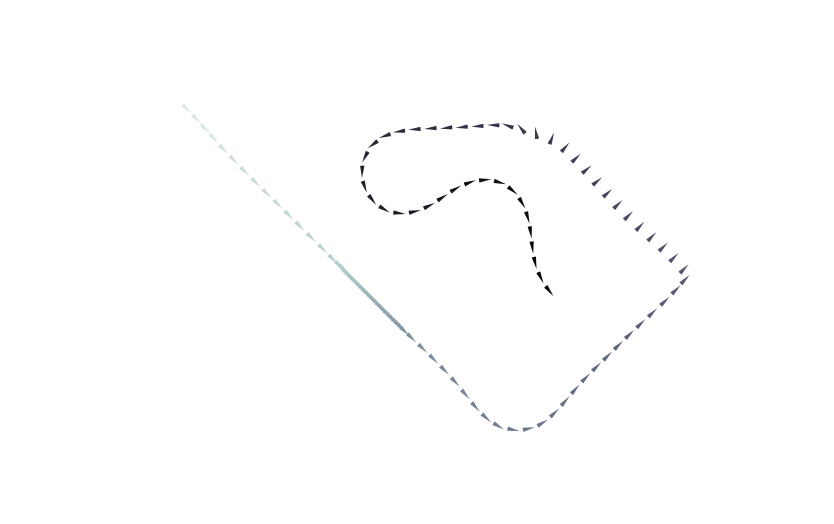

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(3 * 1, 3 * 1), sharex=True, sharey=True, dpi=300)

ff.plot_trajectory(x_sim['x'], x_sim['y'], x_sim['psi'],
                   color=t_sim,
                   ax=ax,
                   size_radius=0.08,
                   nskip=0)

fifi.mpl_functions.adjust_spines(ax, [])

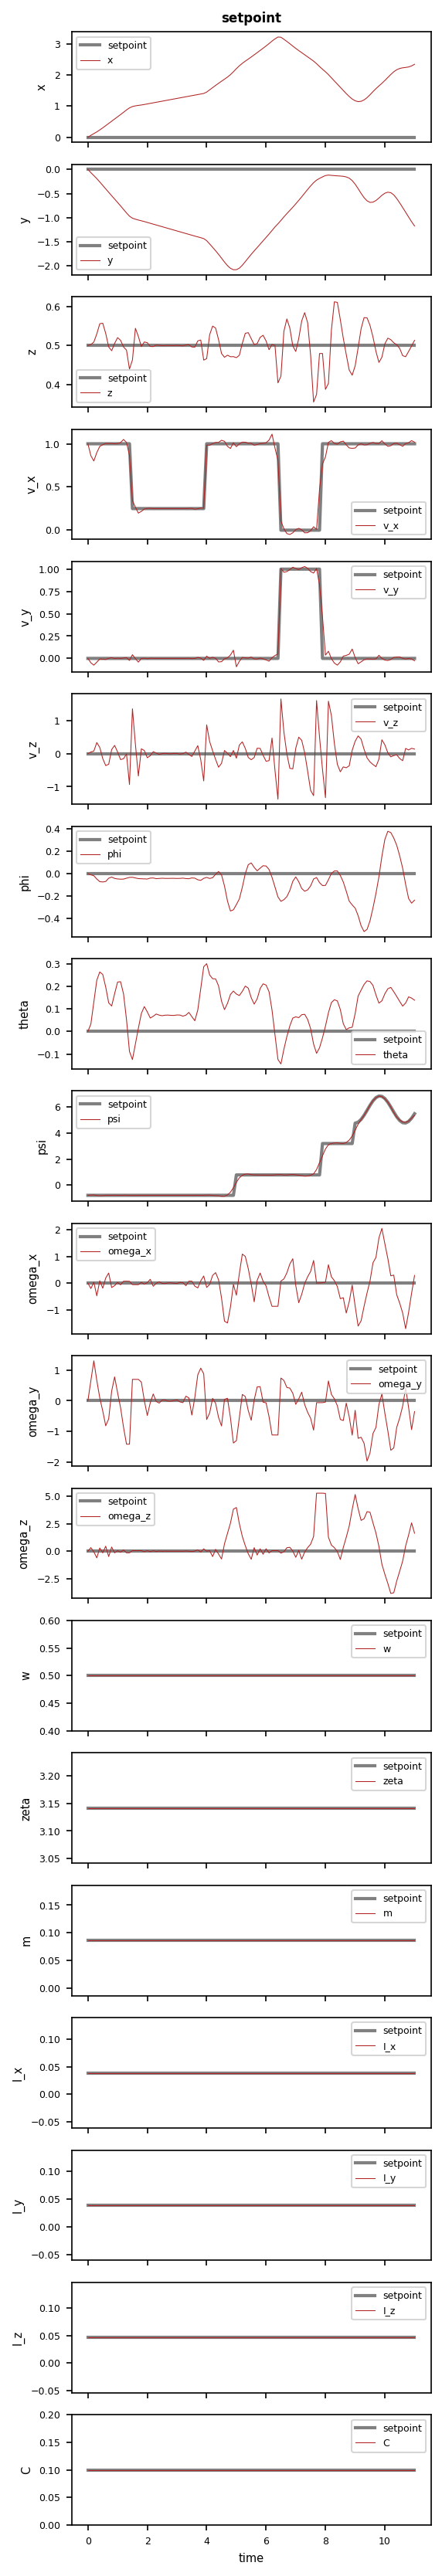

In [119]:
simulator.plot(name='setpoint')

/tmp/ipykernel_1199662/138927273.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


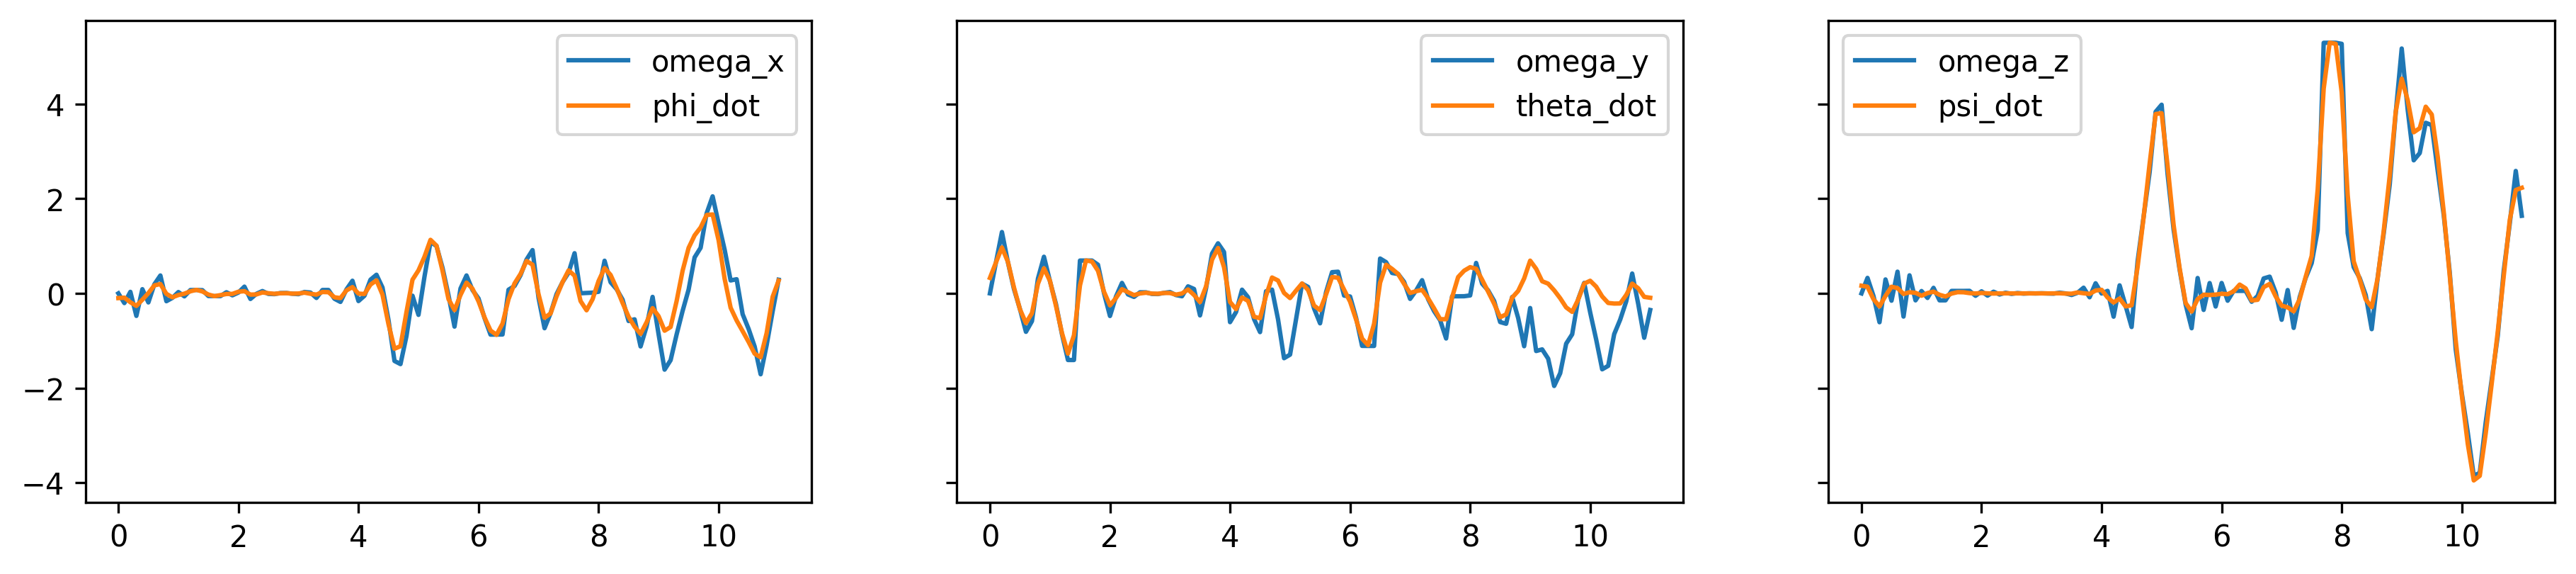

In [120]:
# plot omega_x and phi_dot
fig, ax = plt.subplots(1, 3, figsize=(3 * 5, 3 * 1), sharex=True, sharey=True, dpi=300)
ax[0].plot(t_sim, x_sim['omega_x'], label='omega_x')
ax[0].plot(t_sim, np.gradient(x_sim['phi'], t_sim), label='phi_dot')
ax[0].legend()
ax[1].plot(t_sim, x_sim['omega_y'], label='omega_y')
ax[1].plot(t_sim, np.gradient(x_sim['theta'], t_sim), label='theta_dot')
ax[1].legend()
ax[2].plot(t_sim, x_sim['omega_z'], label='omega_z')
ax[2].plot(t_sim, np.gradient(x_sim['psi'], t_sim), label='psi_dot')
ax[2].legend()
fig.show()

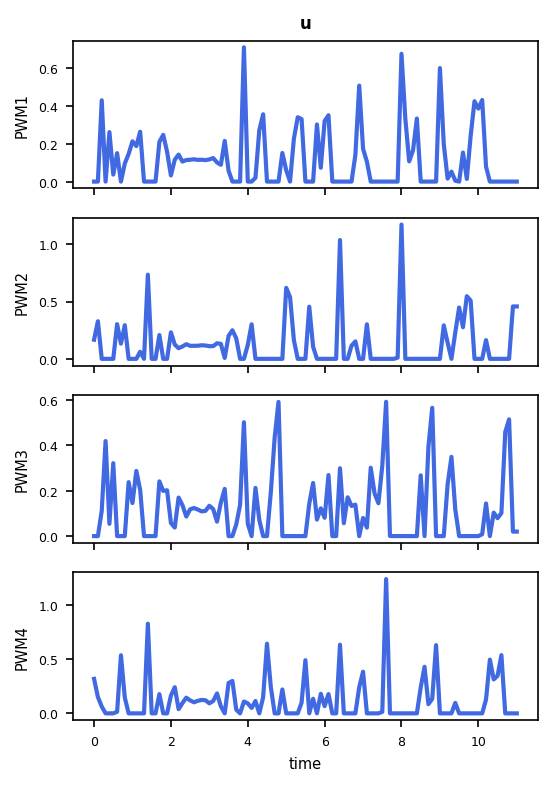

In [121]:
simulator.plot(name='u')

In [122]:
# #plot original trajectory
# X_target = np.cumsum(v_x) * dt
# Y_target = np.cumsum(v_y) * dt
# print('target x:', Y_target)
# plt.plot(X_target, Y_target, color='red', linewidth=5)
# # plot x and y sim have color as time
# plt.plot(x_sim['x'], x_sim['y'], color='blue', linewidth=0.5)

# # plt.scatter(x_sim['x'], x_sim['y'], c=t_sim, cmap='viridis', s=5)

# Observability

In [123]:
# Set time-window
time_window = 8

In [124]:
# Set time-window
time_window = 8

In [125]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=time_window, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 97.83623886108398


In [126]:
# Get O's
O_sliding = SEOM.get_observability_matrix()
n_window = len(O_sliding)
print(n_window, 'windows')

104 windows


In [127]:
o_sensors = ['psi', 'beta', 'gamma']
# o_sensors = ['psi', 'phi', 'theta', 'alpha', 'gamma']
# o_sensors = ['psi', 'phi', 'theta', 'alpha', 'gamma']
# o_sensors = ['psi', 'beta', 'gamma']
# o_sensors = ['psi', 'alpha', 'gamma', 'q', 'r']

o_states = None
# o_states = simulator.state_names[0:-5] + ['m', 'C', 'I_x']

window_size = 5
o_time_steps = np.arange(0, window_size, step=1)

In [128]:
o_states

In [129]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=0.1,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=window_size)

EV_aligned = SFO.get_minimum_error_variance()
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

In [130]:
EV_no_nan

time  time_initial          x          y          z            v_x  \
0     0.0           0.0  1000000.0  1000000.0  1000000.0  793773.014212   
1     0.1           0.0  1000000.0  1000000.0  1000000.0  793773.014212   
2     0.2           0.0  1000000.0  1000000.0  1000000.0  793773.014212   
3     0.3           0.1  1000000.0  1000000.0  1000000.0  735634.052940   
4     0.4           0.2  1000000.0  1000000.0  1000000.0  711594.675294   
..    ...           ...        ...        ...        ...            ...   
106  10.6          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
107  10.7          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
108  10.8          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
109  10.9          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
110  11.0          10.3  1000000.0  1000000.0  1000000.0  790649.625561   

             v_y            v_z           phi        theta  ...       omega_x  \
0       0.094525  999999.999925     64.641627   501.115348  ...   1905.392848   
1       0.094525  999999.999925     64.641627   501.115348  ...   1905.392848   
2       0.094525  999999.999925     64.641627   501.115348  ...   1905.392848   
3    2410.170648  999999.999989      2.080315    62.291007  ...    817.433131   
4    6339.069014  999999.999893      3.584712   456.155226  ...    276.082973   
..           ...            ...           ...          ...  ...           ...   
106    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
107    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
108    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
109    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
110    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   

          omega_y       omega_z              w          zeta            m  \
0    18894.102655     95.993439  218279.815464  44209.813440  6469.673963   
1    18894.102655     95.993439  218279.815464  44209.813440  6469.673963   
2    18894.102655     95.993439  218279.815464  44209.813440  6469.673963   
3     9256.932419     42.974978  253171.485949  15319.274046  7417.765962   
4    21539.514949     37.427324  300565.126307  71803.346048  8251.641725   
..            ...           ...            ...           ...          ...   
106   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
107   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
108   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
109   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
110   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   

            I_x         I_y       I_z             C  
0    326.763743  105.705269  1.556289   8849.452188  
1    326.763743  105.705269  1.556289   8849.452188  
2    326.763743  105.705269  1.556289   8849.452188  
3     10.977623   38.946161  1.231781  10092.377964  
4     10.690389   16.057422  1.916645  11060.424276  
..          ...         ...       ...           ...  
106   62.939263   34.236136  2.480439  15472.214353  
107   62.939263   34.236136  2.480439  15472.214353  
108   62.939263   34.236136  2.480439  15472.214353  
109   62.939263   34.236136  2.480439  15472.214353  
110   62.939263   34.236136  2.480439  15472.214353  

[111 rows x 21 columns]

# Plot state observability

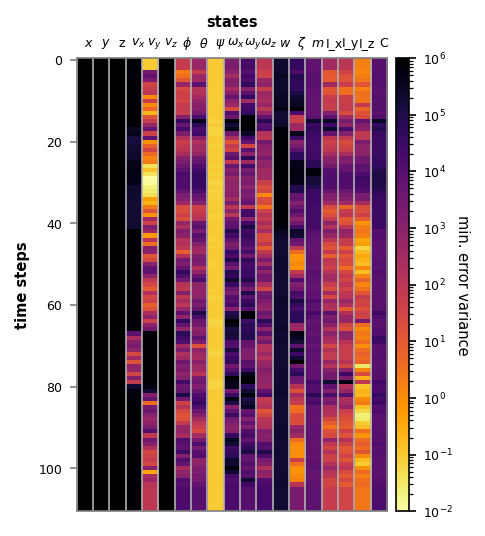

In [131]:
if o_states is None:
    state_labels = simulator.state_names
else:
    state_labels = o_states

cnorm, cmap, log_ticks = ff.plot_heatmap_log_timeseries(EV_no_nan.iloc[:, 2:].values, log_ticks=(-2, 6),
                                                        data_labels=state_labels, y_label='min. error variance')

In [132]:
EV_no_nan

time  time_initial          x          y          z            v_x  \
0     0.0           0.0  1000000.0  1000000.0  1000000.0  793773.014212   
1     0.1           0.0  1000000.0  1000000.0  1000000.0  793773.014212   
2     0.2           0.0  1000000.0  1000000.0  1000000.0  793773.014212   
3     0.3           0.1  1000000.0  1000000.0  1000000.0  735634.052940   
4     0.4           0.2  1000000.0  1000000.0  1000000.0  711594.675294   
..    ...           ...        ...        ...        ...            ...   
106  10.6          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
107  10.7          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
108  10.8          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
109  10.9          10.3  1000000.0  1000000.0  1000000.0  790649.625561   
110  11.0          10.3  1000000.0  1000000.0  1000000.0  790649.625561   

             v_y            v_z           phi        theta  ...       omega_x  \
0       0.094525  999999.999925     64.641627   501.115348  ...   1905.392848   
1       0.094525  999999.999925     64.641627   501.115348  ...   1905.392848   
2       0.094525  999999.999925     64.641627   501.115348  ...   1905.392848   
3    2410.170648  999999.999989      2.080315    62.291007  ...    817.433131   
4    6339.069014  999999.999893      3.584712   456.155226  ...    276.082973   
..           ...            ...           ...          ...  ...           ...   
106    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
107    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
108    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
109    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   
110    95.421542  999999.999994  16686.309723  8896.727044  ...  17401.096036   

          omega_y       omega_z              w          zeta            m  \
0    18894.102655     95.993439  218279.815464  44209.813440  6469.673963   
1    18894.102655     95.993439  218279.815464  44209.813440  6469.673963   
2    18894.102655     95.993439  218279.815464  44209.813440  6469.673963   
3     9256.932419     42.974978  253171.485949  15319.274046  7417.765962   
4    21539.514949     37.427324  300565.126307  71803.346048  8251.641725   
..            ...           ...            ...           ...          ...   
106   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
107   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
108   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
109   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   
110   9314.628959  20729.115206  197359.476348   2029.488781  7058.805349   

            I_x         I_y       I_z             C  
0    326.763743  105.705269  1.556289   8849.452188  
1    326.763743  105.705269  1.556289   8849.452188  
2    326.763743  105.705269  1.556289   8849.452188  
3     10.977623   38.946161  1.231781  10092.377964  
4     10.690389   16.057422  1.916645  11060.424276  
..          ...         ...       ...           ...  
106   62.939263   34.236136  2.480439  15472.214353  
107   62.939263   34.236136  2.480439  15472.214353  
108   62.939263   34.236136  2.480439  15472.214353  
109   62.939263   34.236136  2.480439  15472.214353  
110   62.939263   34.236136  2.480439  15472.214353  

[111 rows x 21 columns]

# Plot state observability on trajectory

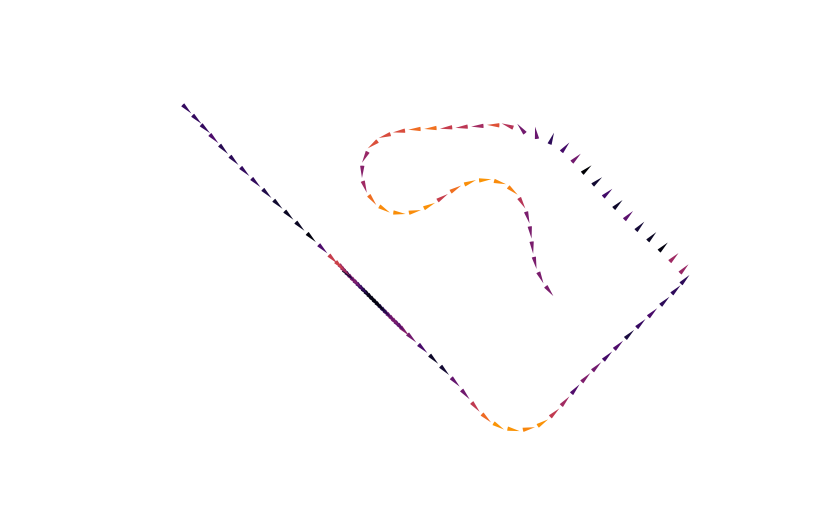

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(3 * 1, 3 * 1), sharex=True, sharey=True, dpi=300)

color = EV_no_nan['zeta'].values

ff.plot_trajectory(x_sim['x'], x_sim['y'], x_sim['psi'],
                   color=color,
                   ax=ax,
                   size_radius=0.08,
                   nskip=0,
                   colormap=cmap,
                   colornorm=cnorm)


fifi.mpl_functions.adjust_spines(ax, [])

# get parameters

In [134]:
DroneParams = DroneParameters()
params = DroneParams.get_params()
print(params)

{'g': 9.81, 'm': 0.086, 'M': 2.529, 'Mm': 2.8729999999999998, 'L': 0.2032, 'R': 0.1778, 'I_x': 0.039081470224, 'I_y': 0.039081470224, 'I_z': 0.046183391504, 'b': 1.8311, 'd': 1, 'C': 0.1}


# creat measuerments form sim

In [135]:
# creat measuerments from the simulation states
#control inputs
Lx = 2*params['L']/np.sqrt(2)
PWM1 = u_sim['PWM1']
PWM2 = u_sim['PWM2']
PWM3 = u_sim['PWM3']
PWM4 = u_sim['PWM4']
#u_thrust = self.params.b * (PWM1 + PWM2 + PWM3 + PWM4)
u_thrust = params['b']*(PWM1 + PWM2 + PWM3 + PWM4)
#u_phi = self.params.b * Lx * (-PWM1 + PWM2 + PWM3 - PWM4)
u_phi = params['b']*Lx*(-PWM1 + PWM2 + PWM3 - PWM4)
#u_theta = self.params.b * Lx * (-PWM1 + PWM2 - PWM3 + PWM4)
u_theta = params['b']*Lx*(-PWM1 + PWM2 - PWM3 + PWM4)
#u_psi = self.params.d * (-PWM1 - PWM2 + PWM3 + PWM4)
u_psi = params['d']*(-PWM1 - PWM2 + PWM3 + PWM4)

# Rotation
# phi_dot = omega_x + omega_z * np.tan(theta) * np.cos(phi) + omega_y * np.tan(theta) * np.sin(phi)
phi_dot = x_sim['omega_x'] + x_sim['omega_z'] * np.tan(x_sim['theta']) * np.cos(x_sim['phi']) + x_sim['omega_y'] * np.tan(x_sim['theta']) * np.sin(x_sim['phi'])
# theta_dot = omega_y * np.cos(phi) - omega_z * np.sin(phi)
theta_dot = x_sim['omega_y'] * np.cos(x_sim['phi']) - x_sim['omega_z'] * np.sin(x_sim['phi'])
# psi_dot = omega_z * np.cos(phi) * (1 / np.cos(theta)) + omega_y * np.sin(phi) * (1 / np.cos(theta))
psi_dot = x_sim['omega_z'] * np.cos(x_sim['phi']) * (1 / np.cos(x_sim['theta'])) + x_sim['omega_y'] * np.sin(x_sim['phi']) * (1 / np.cos(x_sim['theta']))

# mocap
##pose
mocap_pose_noise = 0.01
Px = x_sim['x'] + np.random.normal(0, mocap_pose_noise, len(x_sim['x']))
Py = x_sim['y'] + np.random.normal(0, mocap_pose_noise, len(x_sim['y']))
Pz = x_sim['z'] + np.random.normal(0, mocap_pose_noise, len(x_sim['z']))
##vel
mocap_vel_noise = 0.01
Vx = x_sim['v_x'] + np.random.normal(0, mocap_vel_noise, len(x_sim['v_x']))
Vy = x_sim['v_y'] + np.random.normal(0, mocap_vel_noise, len(x_sim['v_y']))
Vz = x_sim['v_z'] + np.random.normal(0, mocap_vel_noise, len(x_sim['v_z']))
##attitude
mocap_att_noise = 0.01
Phi = x_sim['phi'] + np.random.normal(0, mocap_att_noise, len(x_sim['phi']))
Theta = x_sim['theta'] + np.random.normal(0, mocap_att_noise, len(x_sim['theta']))
Psi = x_sim['psi'] + np.random.normal(0, mocap_att_noise, len(x_sim['psi']))
# imu
##rate
imu_rate_noise = 0.01
Omega_x = x_sim['omega_x'] + np.random.normal(0, imu_rate_noise, len(x_sim['omega_x']))
Omega_y = x_sim['omega_y'] + np.random.normal(0, imu_rate_noise, len(x_sim['omega_y']))
Omega_z = x_sim['omega_z'] + np.random.normal(0, imu_rate_noise, len(x_sim['omega_z']))
##acc
imu_acc_noise = 0.01
# Drag dynamics
# a_x = v_x - w * np.cos(psi - zeta)
a_x = x_sim['v_x'] - x_sim['w'] * np.cos(x_sim['psi'] - x_sim['zeta'])
# a_y = v_y + w * np.sin(psi - zeta)
a_y = x_sim['v_y'] + x_sim['w'] * np.sin(x_sim['psi'] - x_sim['zeta'])
# a_z = v_z
a_z = x_sim['v_z']
#(1 / m) * (u_thrust * np.cos(phi) * np.sin(theta) - C * a_x) + v_y * psi_dot
Ax = (1 / x_sim['m']) * (u_thrust * np.cos(x_sim['phi']) * np.sin(x_sim['theta']) - x_sim['C'] * a_x) + x_sim['v_y'] * psi_dot + np.random.normal(0, imu_acc_noise, len(x_sim['x']))
#(1 / m) * (-u_thrust * np.sin(phi) - C * a_y) - v_x * psi_dot
Ay = (1 / x_sim['m']) * (-u_thrust * np.sin(x_sim['phi']) - x_sim['C'] * a_y) - x_sim['v_x'] * psi_dot + np.random.normal(0, imu_acc_noise, len(x_sim['y']))
#v_z_dot = (1 / m) * (u_thrust * np.cos(phi) * np.cos(theta) - C * v_z - m * g)
Az = (1 / x_sim['m']) * (u_thrust * np.cos(x_sim['phi']) * np.cos(x_sim['theta']) - x_sim['C'] * x_sim['v_z'] - x_sim['m'] * params['g']) + np.random.normal(0, imu_acc_noise, len(x_sim['v_z']))
#optical flow
optical_flow_noise = 0.01
#OF_x = v_x*(1/z)
OF_x = x_sim['v_x'] * (1 / x_sim['z']) + np.random.normal(0, optical_flow_noise, len(x_sim['v_x']))
#OF_y = v_y*(1/z)
OF_y = x_sim['v_y'] * (1 / x_sim['z']) + np.random.normal(0, optical_flow_noise, len(x_sim['v_y']))
#OF_z = v_z*(1/z)
OF_z = x_sim['v_z'] * (1 / x_sim['z']) + np.random.normal(0, optical_flow_noise, len(x_sim['v_z']))
# wind
wind_noise = 0.01
#a_x = v_x - w * np.cos(psi - zeta)
Aw_x = x_sim['v_x'] - w * np.cos(x_sim['psi'] - x_sim['zeta']) + np.random.normal(0, wind_noise, len(x_sim['v_x']))
#a_y = v_y + w * np.sin(psi - zeta)
Aw_y = x_sim['v_y'] + w * np.sin(x_sim['psi'] - x_sim['zeta']) + np.random.normal(0, wind_noise, len(x_sim['v_y']))
#a_z = v_z
Aw_z = x_sim['v_z'] + np.random.normal(0, wind_noise, len(x_sim['v_z']))
#a = np.sqrt(a_x ** 2 + a_y ** 2)
Aa = np.sqrt(Aw_x ** 2 + Aw_y ** 2)
#gamma = np.arctan2(a_y, a_x)
Agamma = np.arctan2(Aw_y, Aw_x)

# Plotting the measuerments

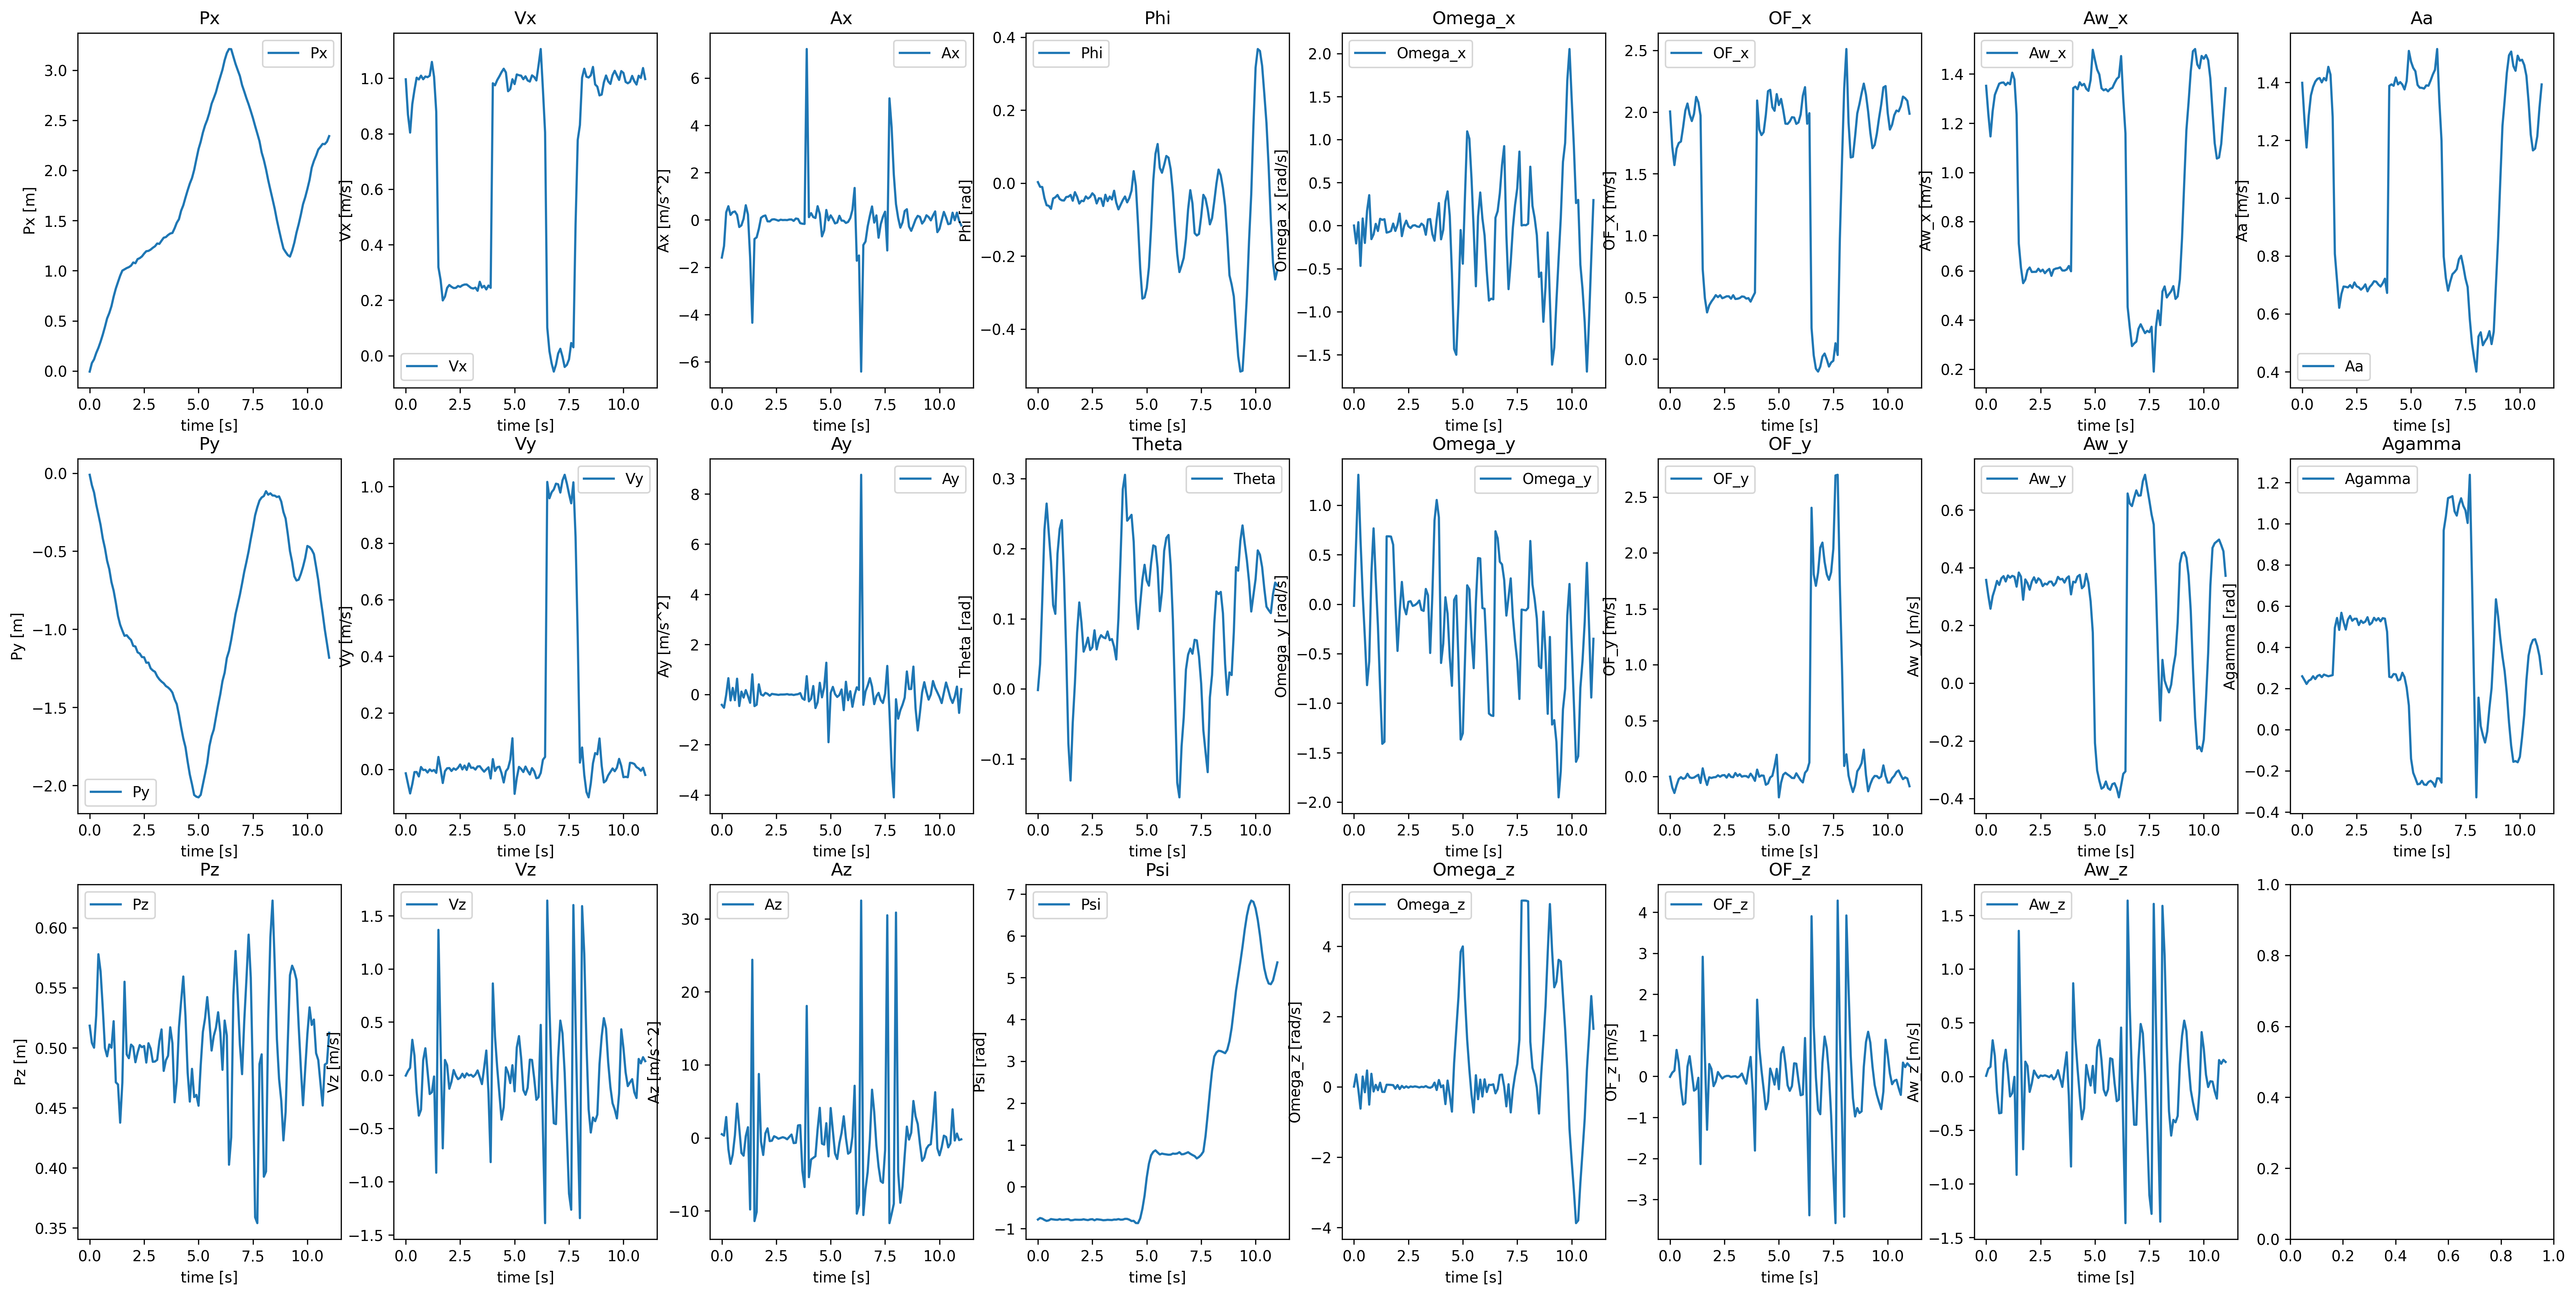

In [136]:
# plot the measurements
fig, ax = plt.subplots(3,8, figsize=(3 * 10, 3 * 5), dpi=300)
ax[0,0].plot(t_sim, Px, label='Px')
ax[0,0].set_title('Px')
ax[0,0].set_xlabel('time [s]')
ax[0,0].set_ylabel('Px [m]')
ax[0,0].legend()

ax[1,0].plot(t_sim, Py, label='Py')
ax[1,0].set_title('Py')
ax[1,0].set_xlabel('time [s]')
ax[1,0].set_ylabel('Py [m]')
ax[1,0].legend()

ax[2,0].plot(t_sim, Pz, label='Pz')
ax[2,0].set_title('Pz')
ax[2,0].set_xlabel('time [s]')
ax[2,0].set_ylabel('Pz [m]')
ax[2,0].legend()

ax[0,1].plot(t_sim, Vx, label='Vx')
ax[0,1].set_title('Vx')
ax[0,1].set_xlabel('time [s]')
ax[0,1].set_ylabel('Vx [m/s]')
ax[0,1].legend()

ax[1,1].plot(t_sim, Vy, label='Vy')
ax[1,1].set_title('Vy')
ax[1,1].set_xlabel('time [s]')
ax[1,1].set_ylabel('Vy [m/s]')
ax[1,1].legend()

ax[2,1].plot(t_sim, Vz, label='Vz')
ax[2,1].set_title('Vz')
ax[2,1].set_xlabel('time [s]')
ax[2,1].set_ylabel('Vz [m/s]')
ax[2,1].legend()

ax[0,2].plot(t_sim, Ax, label='Ax')
ax[0,2].set_title('Ax')
ax[0,2].set_xlabel('time [s]')
ax[0,2].set_ylabel('Ax [m/s^2]')
ax[0,2].legend()

ax[1,2].plot(t_sim, Ay, label='Ay')
ax[1,2].set_title('Ay')
ax[1,2].set_xlabel('time [s]')
ax[1,2].set_ylabel('Ay [m/s^2]')
ax[1,2].legend()

ax[2,2].plot(t_sim, Az, label='Az')
ax[2,2].set_title('Az')
ax[2,2].set_xlabel('time [s]')
ax[2,2].set_ylabel('Az [m/s^2]')
ax[2,2].legend()

ax[0,3].plot(t_sim, Phi, label='Phi')
ax[0,3].set_title('Phi')
ax[0,3].set_xlabel('time [s]')
ax[0,3].set_ylabel('Phi [rad]')
ax[0,3].legend()

ax[1,3].plot(t_sim, Theta, label='Theta')
ax[1,3].set_title('Theta')
ax[1,3].set_xlabel('time [s]')
ax[1,3].set_ylabel('Theta [rad]')
ax[1,3].legend()

ax[2,3].plot(t_sim, Psi, label='Psi')
ax[2,3].set_title('Psi')
ax[2,3].set_xlabel('time [s]')
ax[2,3].set_ylabel('Psi [rad]')
ax[2,3].legend()

ax[0,4].plot(t_sim, Omega_x, label='Omega_x')
ax[0,4].set_title('Omega_x')
ax[0,4].set_xlabel('time [s]')
ax[0,4].set_ylabel('Omega_x [rad/s]')
ax[0,4].legend()

ax[1,4].plot(t_sim, Omega_y, label='Omega_y')
ax[1,4].set_title('Omega_y')
ax[1,4].set_xlabel('time [s]')
ax[1,4].set_ylabel('Omega_y [rad/s]')
ax[1,4].legend()

ax[2,4].plot(t_sim, Omega_z, label='Omega_z')
ax[2,4].set_title('Omega_z')
ax[2,4].set_xlabel('time [s]')
ax[2,4].set_ylabel('Omega_z [rad/s]')
ax[2,4].legend()

ax[0,5].plot(t_sim, OF_x, label='OF_x')
ax[0,5].set_title('OF_x')
ax[0,5].set_xlabel('time [s]')
ax[0,5].set_ylabel('OF_x [m/s]')
ax[0,5].legend()

ax[1,5].plot(t_sim, OF_y, label='OF_y')
ax[1,5].set_title('OF_y')
ax[1,5].set_xlabel('time [s]')
ax[1,5].set_ylabel('OF_y [m/s]')
ax[1,5].legend()

ax[2,5].plot(t_sim, OF_z, label='OF_z')
ax[2,5].set_title('OF_z')
ax[2,5].set_xlabel('time [s]')
ax[2,5].set_ylabel('OF_z [m/s]')
ax[2,5].legend()

ax[0,6].plot(t_sim, Aw_x, label='Aw_x')
ax[0,6].set_title('Aw_x')
ax[0,6].set_xlabel('time [s]')
ax[0,6].set_ylabel('Aw_x [m/s]')
ax[0,6].legend()

ax[1,6].plot(t_sim, Aw_y, label='Aw_y')
ax[1,6].set_title('Aw_y')
ax[1,6].set_xlabel('time [s]')
ax[1,6].set_ylabel('Aw_y [m/s]')
ax[1,6].legend()

ax[2,6].plot(t_sim, Aw_z, label='Aw_z')
ax[2,6].set_title('Aw_z')
ax[2,6].set_xlabel('time [s]')
ax[2,6].set_ylabel('Aw_z [m/s]')
ax[2,6].legend()

ax[0,7].plot(t_sim, Aa, label='Aa')
ax[0,7].set_title('Aa')
ax[0,7].set_xlabel('time [s]')
ax[0,7].set_ylabel('Aa [m/s]')
ax[0,7].legend()

ax[1,7].plot(t_sim, Agamma, label='Agamma')
ax[1,7].set_title('Agamma')
ax[1,7].set_xlabel('time [s]')
ax[1,7].set_ylabel('Agamma [rad]')
ax[1,7].legend()



# measuerment cluster

In [182]:
Y_flag = 'real'
if Y_flag == 'all':
     Y_m = np.vstack((Px, Py, Pz, Vx, Vy, Vz, Phi, Theta, Psi, Omega_x, Omega_y, Omega_z, Ax, Ay, Az, OF_x, OF_y, OF_z, Aw_x, Aw_y, Aw_z, Aa, Agamma))
elif Y_flag == 'real':
     Y_m = np.vstack((Omega_x, Omega_y, Omega_z, Ax, Ay, Az, OF_x, OF_y, Aw_x, Aw_y, Aa, Agamma))

# set the control input cluster

In [183]:
U = np.vstack((PWM1, PWM2, PWM3, PWM4))

# set the Xo values

In [184]:
X0 = np.atleast_2d(np.vstack((x_sim['x'][0]+.25,
                              x_sim['y'][0]+.25,
                              x_sim['z'][0]+.25,
                              x_sim['v_x'][0]+.25,
                              x_sim['v_y'][0]+.25,
                              x_sim['v_z'][0]+.25,
                              x_sim['phi'][0]+x_sim['phi'][0]*.25,
                              x_sim['theta'][0]+x_sim['theta'][0]*.25,
                              x_sim['psi'][0]+x_sim['psi'][0]*.25,
                              x_sim['omega_x'][0]+.25,
                              x_sim['omega_y'][0]+.25,
                              x_sim['omega_z'][0]+.25,
                              x_sim['w'][0]+x_sim['w'][0]*.25,
                              x_sim['zeta'][0]+x_sim['zeta'][0]*.25,
                              x_sim['m'][0]+x_sim['m'][0]*.25,
                              x_sim['I_x'][0]+x_sim['I_x'][0]*.25,
                              x_sim['I_y'][0]+x_sim['I_y'][0]*.25,
                              x_sim['I_z'][0]+x_sim['I_z'][0]*.25,
                              x_sim['C'][0]+x_sim['C'][0]*.25)))

# set Q for dynamics modle

In [185]:
Q = np.diag(np.array([1e-5, # x
                      1e-5, # y
                      1e-5, # z
                      1e-5, # v_x
                      1e-5, # v_y
                      1e-5, # v_z
                      1e-5, # phi
                      1e-5, # theta
                      1e-5, # psi
                      1e-5, # omega_x
                      1e-5, # omega_y
                      1e-5, # omega_z
                      1e-5, # w
                      1e-2, # zeta
                      1e-5, # m
                      1e-5, # I_x
                      1e-5, # I_y
                      1e-5, # I_z
                      1e-5])) # C

# set the measuerment noise covariance

In [186]:
Pxv = mocap_pose_noise
Pyv = mocap_pose_noise
Pzv = mocap_pose_noise
Vxv = mocap_vel_noise
Vyv = mocap_vel_noise
Vzv = mocap_vel_noise
Phiv = mocap_att_noise
Thetav = mocap_att_noise
Psiv = mocap_att_noise
Omega_xv = imu_rate_noise
Omega_yv = imu_rate_noise
Omega_zv = imu_rate_noise
Axv = imu_acc_noise
Ayv = imu_acc_noise
Azv = imu_acc_noise
OF_xv = optical_flow_noise
OF_yv = optical_flow_noise
OF_zv = optical_flow_noise
Aw_xv = wind_noise
Aw_yv = wind_noise
Aw_zv = wind_noise
Aav = wind_noise
Agammav = wind_noise

V_flag = 'real'
if V_flag == 'all':
    V = np.hstack(np.array([Pxv, Pyv, Pzv, Vxv, Vyv, Vzv, Phiv, Thetav, Psiv, Omega_xv, Omega_yv, Omega_zv, Axv, Ayv, Azv, OF_xv, OF_yv, OF_zv, Aw_xv, Aw_yv, Aw_zv, Aav, Agammav]))
elif V_flag == 'real':
    V = np.hstack(np.array([Omega_xv, Omega_yv, Omega_zv, Axv, Ayv, Azv, OF_xv, OF_yv, Aw_xv, Aw_yv, Aav, Agammav]))
R=np.power(np.diag(V), 2)




# setting P0

In [187]:
P0 = np.diag(np.array([1e-2, # x
                       1e-2, # y
                       1e-2, # z
                       1e-2, # v_x
                       1e-2, # v_y
                       1e-2, # v_z
                       1e-2, # phi
                       1e-2, # theta
                       1e-2, # psi
                       1e-2, # omega_x
                       1e-2, # omega_y
                       1e-2, # omega_z
                       1e-2, # w
                       1e-2, # zeta
                       1e-2, # m
                       1e-2, # I_x
                       1e-2, # I_y
                       1e-2, # I_z
                       1e-2])) # C

In [188]:
# check that all inputs are a two-dimensional array
print('Ynoisy:',Y_m.shape)
print('x0:',X0.shape)
print('U:',U.shape)
print('Q:',Q.shape)
print('R:',R.shape)
print('P0:',P0.shape)

Ynoisy: (12, 111)
x0: (19, 1)
U: (4, 111)
Q: (19, 19)
R: (12, 12)
P0: (19, 19)


# get model function

In [189]:
drone_model = DroneModel()
f_c=drone_model.f_c

def outer(func):
    def wrapper(*args, **kwargs):
        global dt
        args = list(args) + [dt]
        value = func(*args)
        return value
    return wrapper

f_c = outer(drone_model.f_c)

# # drone_model.f_c(np.zeros_like(X0),U[:,0],.1)
# f_c(np.zeros_like(X0),U[:,0])

# get measuerment function

In [190]:
h_c=drone_model.h_c

In [191]:
xhat, P, s = EKF(Y_m, X0, f_c, h_c, Q, R, U, P0)

# Estimate

In [192]:
x_hat = xhat[0,:] # x estimate
y_hat = xhat[1,:] # y estimate
z_hat = xhat[2,:] # z estimate
v_x_hat = xhat[3,:] # v_x estimate
v_y_hat = xhat[4,:] # v_y estimate
v_z_hat = xhat[5,:] # v_z estimate
phi_hat = xhat[6,:] # phi estimate
theta_hat = xhat[7,:] # theta estimate
psi_hat = xhat[8,:] # psi estimate
omega_x_hat = xhat[9,:] # omega_x estimate
omega_y_hat = xhat[10,:] # omega_y estimate
omega_z_hat = xhat[11,:] # omega_z estimate
w_hat = xhat[12,:] # w estimate
zeta_hat = xhat[13,:] # zeta estimate
m_hat = xhat[14,:] # m estimate
I_x_hat = xhat[15,:] # I_x estimate
I_y_hat = xhat[16,:] # I_y estimate
I_z_hat = xhat[17,:] # I_z estimate
C_hat = xhat[18,:] # C estimate


# plotting estimates

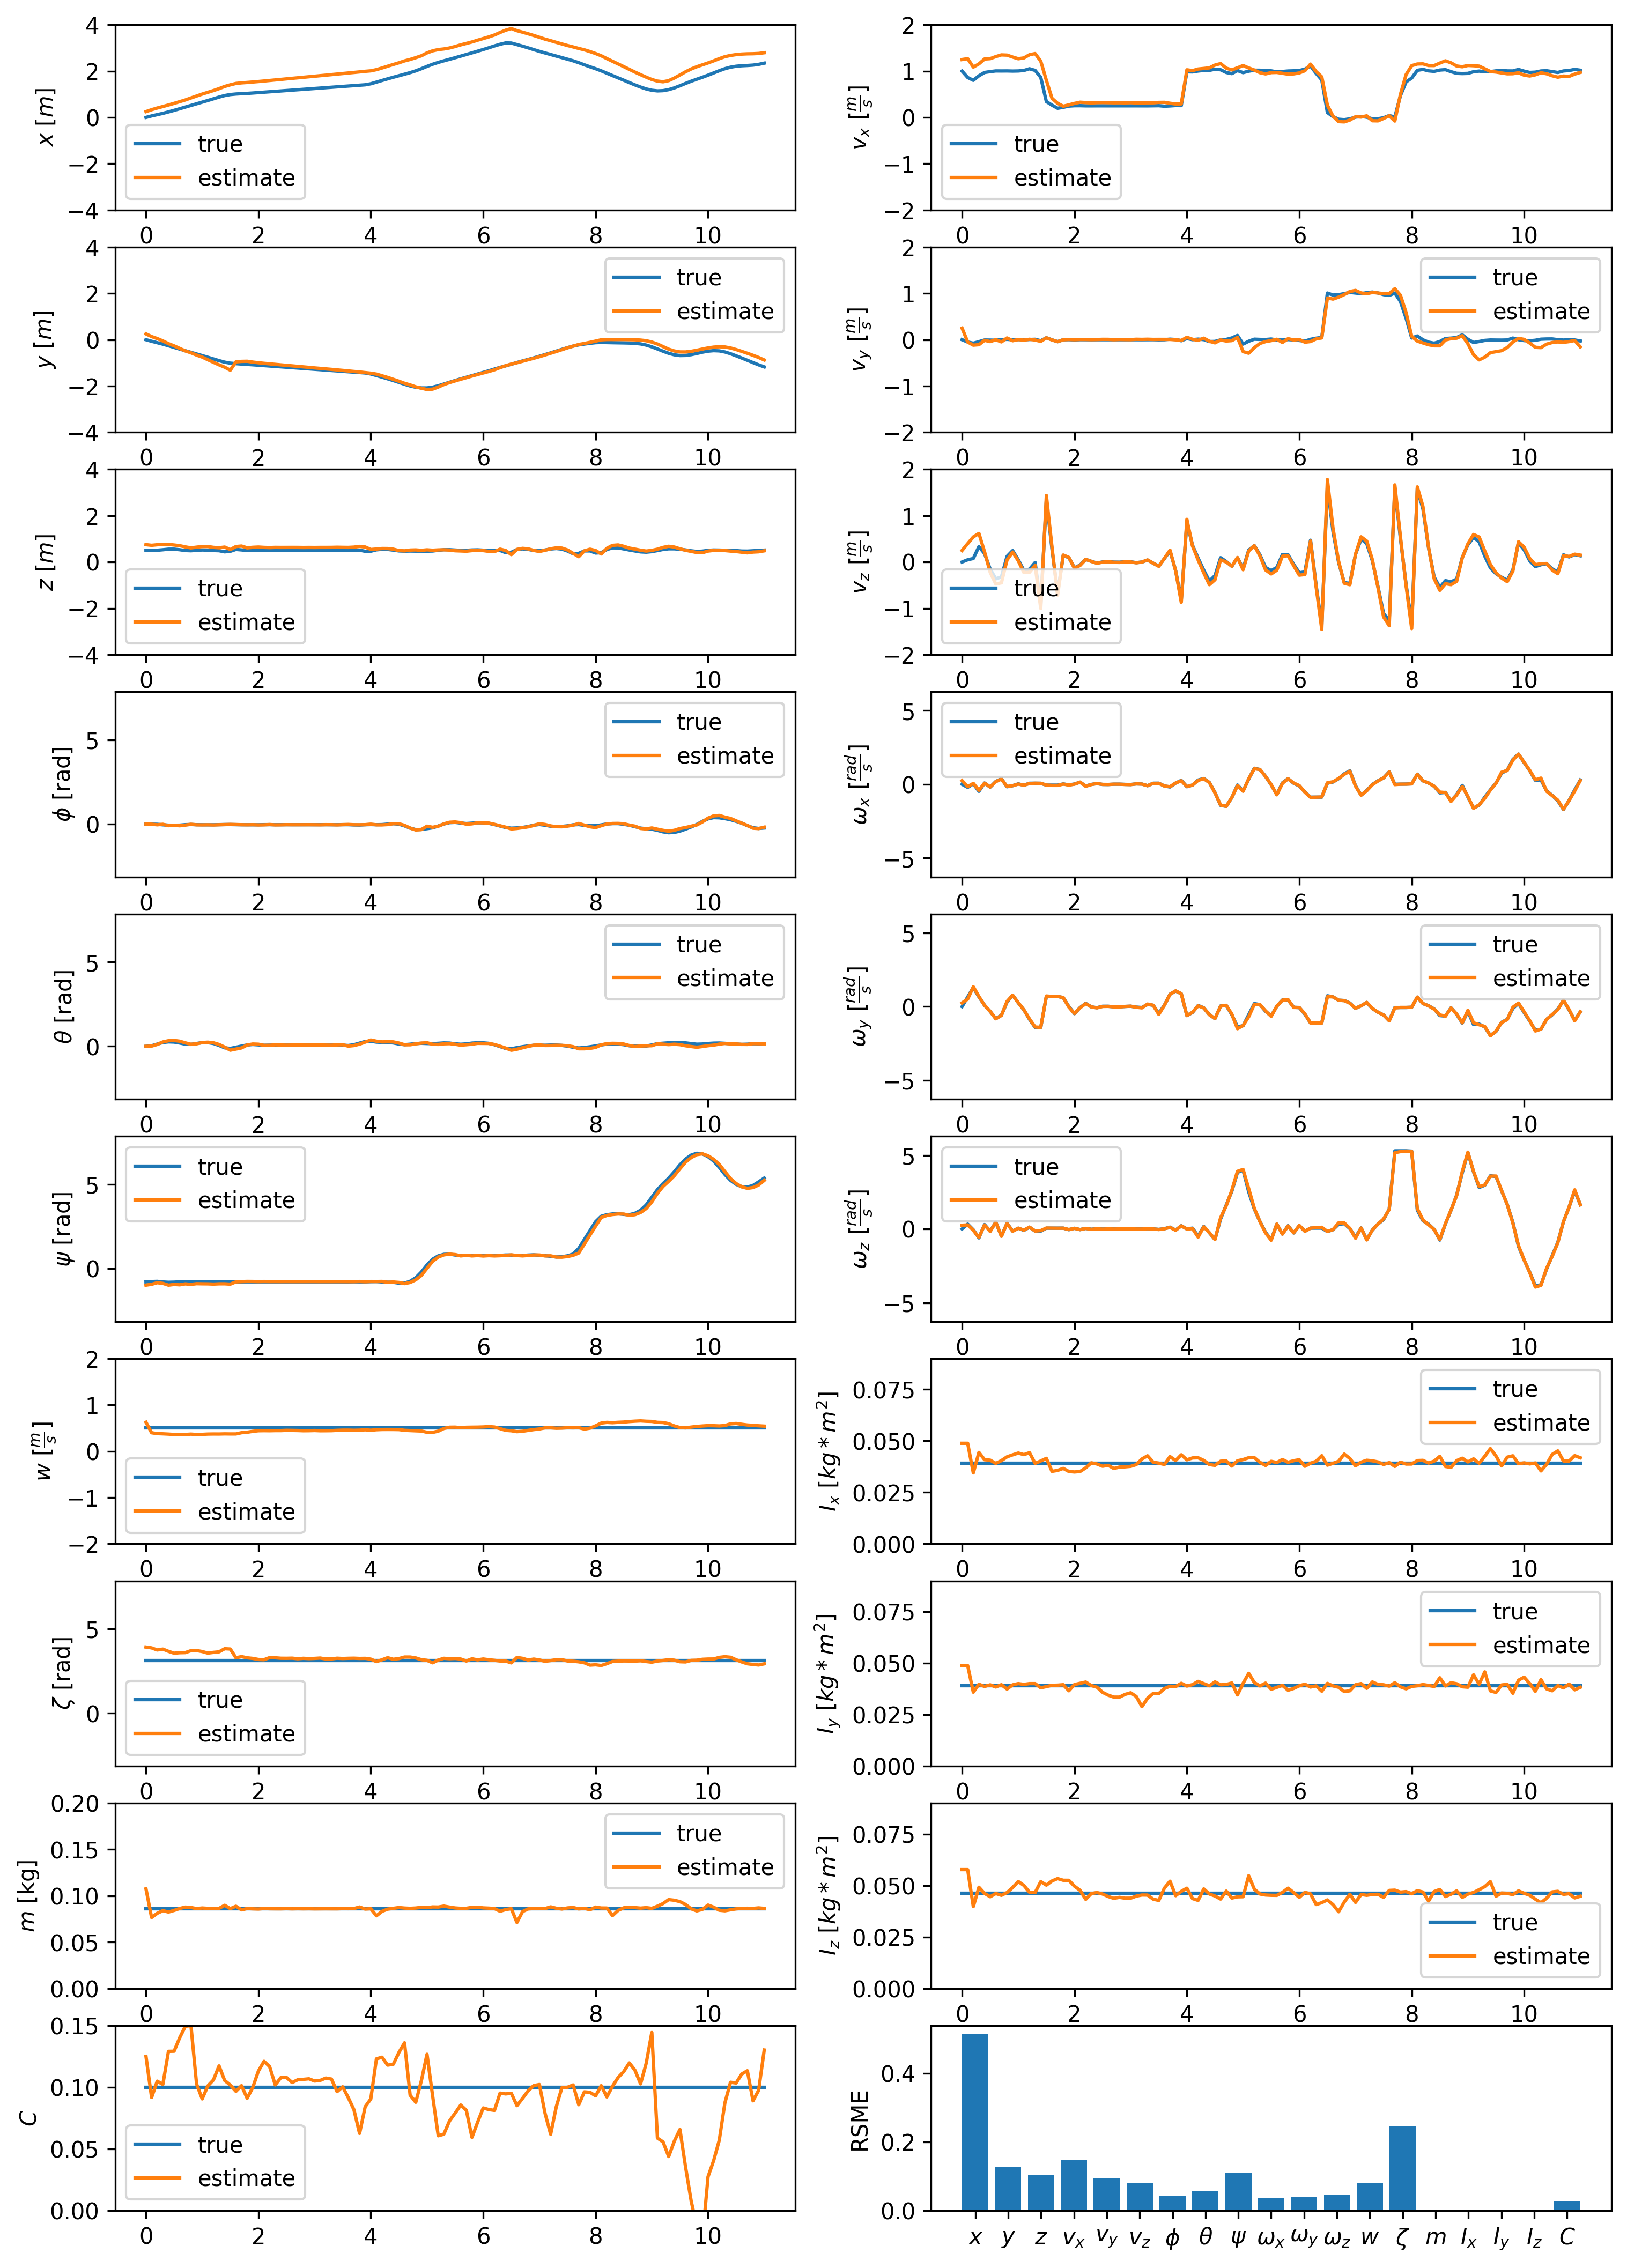

In [193]:
# plot the estimated states and the true states all on the same figure
# 19 states make the plots 10 by 2
fig, ax = plt.subplots(10, 2, figsize=(3 * 4, 3 * 6), dpi=300)
# plot x
ax[0, 0].plot(t_sim, x_sim['x'], label='true')
ax[0, 0].plot(t_sim, x_hat, label='estimate')
ax[0, 0].set_ylabel('$x$ [$m$]')
ax[0, 0].set_ylim(-4, 4)
ax[0, 0].legend()
# plot y
ax[1, 0].plot(t_sim, x_sim['y'], label='true')
ax[1, 0].plot(t_sim, y_hat, label='estimate')
ax[1, 0].set_ylabel('$y$ [$m$]')
ax[1, 0].set_ylim(-4, 4)
ax[1, 0].legend()
# plot z
ax[2, 0].plot(t_sim, x_sim['z'], label='true')
ax[2, 0].plot(t_sim, z_hat, label='estimate')
ax[2, 0].set_ylabel('$z$ [$m$]')
ax[2, 0].set_ylim(-4, 4)
ax[2, 0].legend()
# plot v_x
ax[0, 1].plot(t_sim, x_sim['v_x'], label='true')
ax[0, 1].plot(t_sim, v_x_hat, label='estimate')
ax[0, 1].set_ylabel(r'$v_x$ [$\frac{m}{s}$]')
ax[0, 1].set_ylim(-2, 2)
ax[0, 1].legend()
# plot v_y
ax[1, 1].plot(t_sim, x_sim['v_y'], label='true')
ax[1, 1].plot(t_sim, v_y_hat, label='estimate')
ax[1, 1].set_ylabel(r'$v_y$ [$\frac{m}{s}$]')
ax[1, 1].set_ylim(-2, 2)
ax[1, 1].legend()
# plot v_z
ax[2, 1].plot(t_sim, x_sim['v_z'], label='true')
ax[2, 1].plot(t_sim, v_z_hat, label='estimate')
ax[2, 1].set_ylabel(r'$v_z$ [$\frac{m}{s}$]')
ax[2, 1].set_ylim(-2, 2)
ax[2, 1].legend()
# plot phi
ax[3, 0].plot(t_sim, x_sim['phi'], label='true')
ax[3, 0].plot(t_sim, phi_hat, label='estimate')
ax[3, 0].set_ylabel('$\phi$ [rad]')
ax[3, 0].set_ylim(-np.pi, 2.5*np.pi)
ax[3, 0].legend()
# plot theta
ax[4, 0].plot(t_sim, x_sim['theta'], label='true')
ax[4, 0].plot(t_sim, theta_hat, label='estimate')
ax[4, 0].set_ylabel(r'$\theta$ [rad]')
ax[4, 0].set_ylim(-np.pi, 2.5*np.pi)
ax[4, 0].legend()
# plot psi
ax[5, 0].plot(t_sim, x_sim['psi'], label='true')
ax[5, 0].plot(t_sim, psi_hat, label='estimate')
ax[5, 0].set_ylabel('$\psi$ [rad]')
ax[5, 0].set_ylim(-np.pi, 2.5*np.pi)
ax[5, 0].legend()
# plot omega_x
ax[3, 1].plot(t_sim, x_sim['omega_x'], label='true')
ax[3, 1].plot(t_sim, omega_x_hat, label='estimate')
ax[3, 1].set_ylabel(r'$\omega_x$ [$\frac{rad}{s}$]')
ax[3, 1].set_ylim(-2*np.pi, 2*np.pi)
ax[3, 1].legend()
# plot omega_y
ax[4, 1].plot(t_sim, x_sim['omega_y'], label='true')
ax[4, 1].plot(t_sim, omega_y_hat, label='estimate')
ax[4, 1].set_ylabel(r'$\omega_y$ [$\frac{rad}{s}$]')
ax[4, 1].set_ylim(-2*np.pi, 2*np.pi)
ax[4, 1].legend()
# plot omega_z
ax[5, 1].plot(t_sim, x_sim['omega_z'], label='true')
ax[5, 1].plot(t_sim, omega_z_hat, label='estimate')
ax[5, 1].set_ylabel(r'$\omega_z$ [$\frac{rad}{s}$]')
ax[5, 1].set_ylim(-2*np.pi, 2*np.pi)
ax[5, 1].legend()
# plot w
ax[6, 0].plot(t_sim, x_sim['w'], label='true')
ax[6, 0].plot(t_sim, w_hat, label='estimate')
ax[6, 0].set_ylabel(r'$w$ [$\frac{m}{s}$]')
ax[6, 0].set_ylim(-2, 2)
ax[6, 0].legend()
# plot zeta
ax[7, 0].plot(t_sim, x_sim['zeta'], label='true')
ax[7, 0].plot(t_sim, zeta_hat, label='estimate')
ax[7, 0].set_ylabel('$\zeta$ [rad]')
ax[7, 0].set_ylim(-np.pi, 2.5*np.pi)
ax[7, 0].legend()
# plot m
ax[8, 0].plot(t_sim, x_sim['m'], label='true')
ax[8, 0].plot(t_sim, m_hat, label='estimate')
ax[8, 0].set_ylabel('$m$ [kg]')
ax[8, 0].set_ylim(0, .2)
ax[8, 0].legend()
# plot C
ax[9, 0].plot(t_sim, x_sim['C'], label='true')
ax[9, 0].plot(t_sim, C_hat, label='estimate')
ax[9, 0].set_ylabel('$C$')
ax[9, 0].set_ylim(0, .15)
ax[9, 0].legend()
# plot I_x
ax[6, 1].plot(t_sim, x_sim['I_x'], label='true')
ax[6, 1].plot(t_sim, I_x_hat, label='estimate')
ax[6, 1].set_ylabel('$I_x$ [$kg*m^2$]')
ax[6, 1].set_ylim(0, .09)
ax[6, 1].legend()
# plot I_y
ax[7, 1].plot(t_sim, x_sim['I_y'], label='true')
ax[7, 1].plot(t_sim, I_y_hat, label='estimate')
ax[7, 1].set_ylabel('$I_y$ [$kg*m^2$]')
ax[7, 1].set_ylim(0, .09)
ax[7, 1].legend()
# plot I_z
ax[8, 1].plot(t_sim, x_sim['I_z'], label='true')
ax[8, 1].plot(t_sim, I_z_hat, label='estimate')
ax[8, 1].set_ylabel('$I_z$ [$kg*m^2$]')
ax[8, 1].set_ylim(0, .09)
ax[8, 1].legend()
# calculate error between true and estimated states and plot as a bar graph for fig ax[9,1]
RSME_x = np.sqrt(np.mean((x_sim['x'] - x_hat) ** 2))
RSME_y = np.sqrt(np.mean((x_sim['y'] - y_hat) ** 2))
RSME_z = np.sqrt(np.mean((x_sim['z'] - z_hat) ** 2))
RSME_v_x = np.sqrt(np.mean((x_sim['v_x'] - v_x_hat) ** 2))
RSME_v_y = np.sqrt(np.mean((x_sim['v_y'] - v_y_hat) ** 2))
RSME_v_z = np.sqrt(np.mean((x_sim['v_z'] - v_z_hat) ** 2))
RSME_phi = np.sqrt(np.mean((x_sim['phi'] - phi_hat) ** 2))
RSME_theta = np.sqrt(np.mean((x_sim['theta'] - theta_hat) ** 2))
RSME_psi = np.sqrt(np.mean((x_sim['psi'] - psi_hat) ** 2))
RSME_omega_x = np.sqrt(np.mean((x_sim['omega_x'] - omega_x_hat) ** 2))
RSME_omega_y = np.sqrt(np.mean((x_sim['omega_y'] - omega_y_hat) ** 2))
RSME_omega_z = np.sqrt(np.mean((x_sim['omega_z'] - omega_z_hat) ** 2))
RSME_w = np.sqrt(np.mean((x_sim['w'] - w_hat) ** 2))
RSME_zeta = np.sqrt(np.mean((x_sim['zeta'] - zeta_hat) ** 2))
RSME_m = np.sqrt(np.mean((x_sim['m'] - m_hat) ** 2))
RSME_I_x = np.sqrt(np.mean((x_sim['I_x'] - I_x_hat) ** 2))
RSME_I_y = np.sqrt(np.mean((x_sim['I_y'] - I_y_hat) ** 2))
RSME_I_z = np.sqrt(np.mean((x_sim['I_z'] - I_z_hat) ** 2))
RSME_C = np.sqrt(np.mean((x_sim['C'] - C_hat) ** 2))
RSME = np.array([RSME_x, RSME_y, RSME_z, RSME_v_x, RSME_v_y, RSME_v_z, RSME_phi, RSME_theta, RSME_psi, RSME_omega_x, RSME_omega_y, RSME_omega_z, RSME_w, RSME_zeta, RSME_m, RSME_I_x, RSME_I_y, RSME_I_z, RSME_C])
ax[9, 1].bar(np.arange(19), RSME)
ax[9, 1].set_ylabel('RSME')
ax[9, 1].set_xticks(np.arange(19))
# write x tick lables in latex format
ax[9, 1].set_xticklabels(['$x$', '$y$', '$z$', '$v_x$', '$v_y$', '$v_z$', '$\phi$', r'$\theta$', '$\psi$', '$\omega_x$', '$\omega_y$', '$\omega_z$', '$w$', '$\zeta$', '$m$', '$I_x$', '$I_y$', '$I_z$', '$C$'])

plt.show()





# Import real data

In [69]:
# Load the data
#when using on the laptop path is /home/austin/Drone_AFRL/
#when using on the desktop path is /home/austinlopez/Drone_AFRL/
# sub_path = 'neg_X'
sub_path = 'con_vel'
# sub_path = 'con_vel_con_yaw'
FLAG_FILE = sub_path
path = '/home/austinlopez/Drone_AFRL/CSV/'+ sub_path
all_files = glob.glob(path + "/*.csv")
data = {}

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data[os.path.basename(filename)[len(sub_path)+8:-4]] = df

data = {key.replace("_slash_", "/"): value for key, value in data.items()}

for key in data.keys():
    print(key)

trisonica_global
optic_flow/wind_sensor/mean/y
mavros/local_position/pose
trisonica
trisonica_body_level
optic_flow/wind_sensor/mean/x
mavros/imu/data
optic_flow/global/mean/y
optic_flow/camera/mean/y
mavros/imu/data_raw
optic_flow/global/mean/x
optic_flow/camera/mean/x
mavros/rc/in
mavros/rc/out


# usefull functions

In [70]:
def quaternion_to_euler(x, y, z, w):
    """
    input: x, y, z, w
    output: R, P, Y
    """
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    R = math.degrees(math.atan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    P = math.degrees(math.asin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Y = math.degrees(math.atan2(t3, t4))

    return R, P, Y

# function that interpolates data based on two time arrays using numpy
def interpolate_data(time1, data1, time2):
    """
    input: time1 (interp from), data1 (interp from), time2 (interp to)
    output: interpolated data2
    """
    return np.interp(time2, time1, data1)

# function that takes in data frame and gives out time array based on the columns secs and nsecs
def time_array(data):
    "input: data frame with columns secs and nsecs"
    "output: array of time in seconds"
    time = []
    for i in range(len(data)):
        time.append(data['secs'][i] + data['nsecs'][i] * 1e-9)

    return time

def high_pass_filter(data, dt, cut_off_freq):
    """
    input: data, dt, cut_off_freq
    output: data_filtered
    """
    # Create the high pass filter
    b, a = signal.butter(1, cut_off_freq, 'high', fs=1/dt)
    
    # Apply the high pass filter
    data_filtered = signal.filtfilt(b, a, data)
    
    return data_filtered

def low_pass_filter(data, dt, cut_off_freq):
    """
    input: data, dt, cut_off_freq
    output: data_filtered
    """
    # Create the high pass filter
    b, a = signal.butter(1, cut_off_freq, 'low', fs=1/dt)
    
    # Apply the high pass filter
    data_filtered = signal.filtfilt(b, a, data)
    
    return data_filtered

# Ground Truth MoCap

In [71]:

mocap_time = data['mavros/local_position/pose']['rosbagTimestamp']/1e9
mocap_Roll, mocap_Pitch, mocap_Yaw = [], [], []
for i in range(len(data['mavros/local_position/pose'])):
    R, P, Y = quaternion_to_euler(data['mavros/local_position/pose']['x.1'][i],
                                  data['mavros/local_position/pose']['y.1'][i],
                                  data['mavros/local_position/pose']['z.1'][i],
                                  data['mavros/local_position/pose']['w'][i])
    mocap_Roll.append(R)
    mocap_Pitch.append(P)
    mocap_Yaw.append(Y)

mocap_X = data['mavros/local_position/pose']['x']
mocap_Y = data['mavros/local_position/pose']['y']
mocap_Z = data['mavros/local_position/pose']['z']

mocap_time_shifted = mocap_time - mocap_time[0]
# take the derivative of the mocap data to get the velocities
mocap_X_dot = np.gradient(mocap_X, mocap_time)
mocap_Y_dot = np.gradient(mocap_Y, mocap_time)
mocap_Z_dot = np.gradient(mocap_Z, mocap_time)

# take the derivative of the mocap data to get the accelerations
mocap_X_ddot = np.gradient(mocap_X_dot, mocap_time)
mocap_Y_ddot = np.gradient(mocap_Y_dot, mocap_time)
mocap_Z_ddot = np.gradient(mocap_Z_dot, mocap_time)

## plot all mocap data

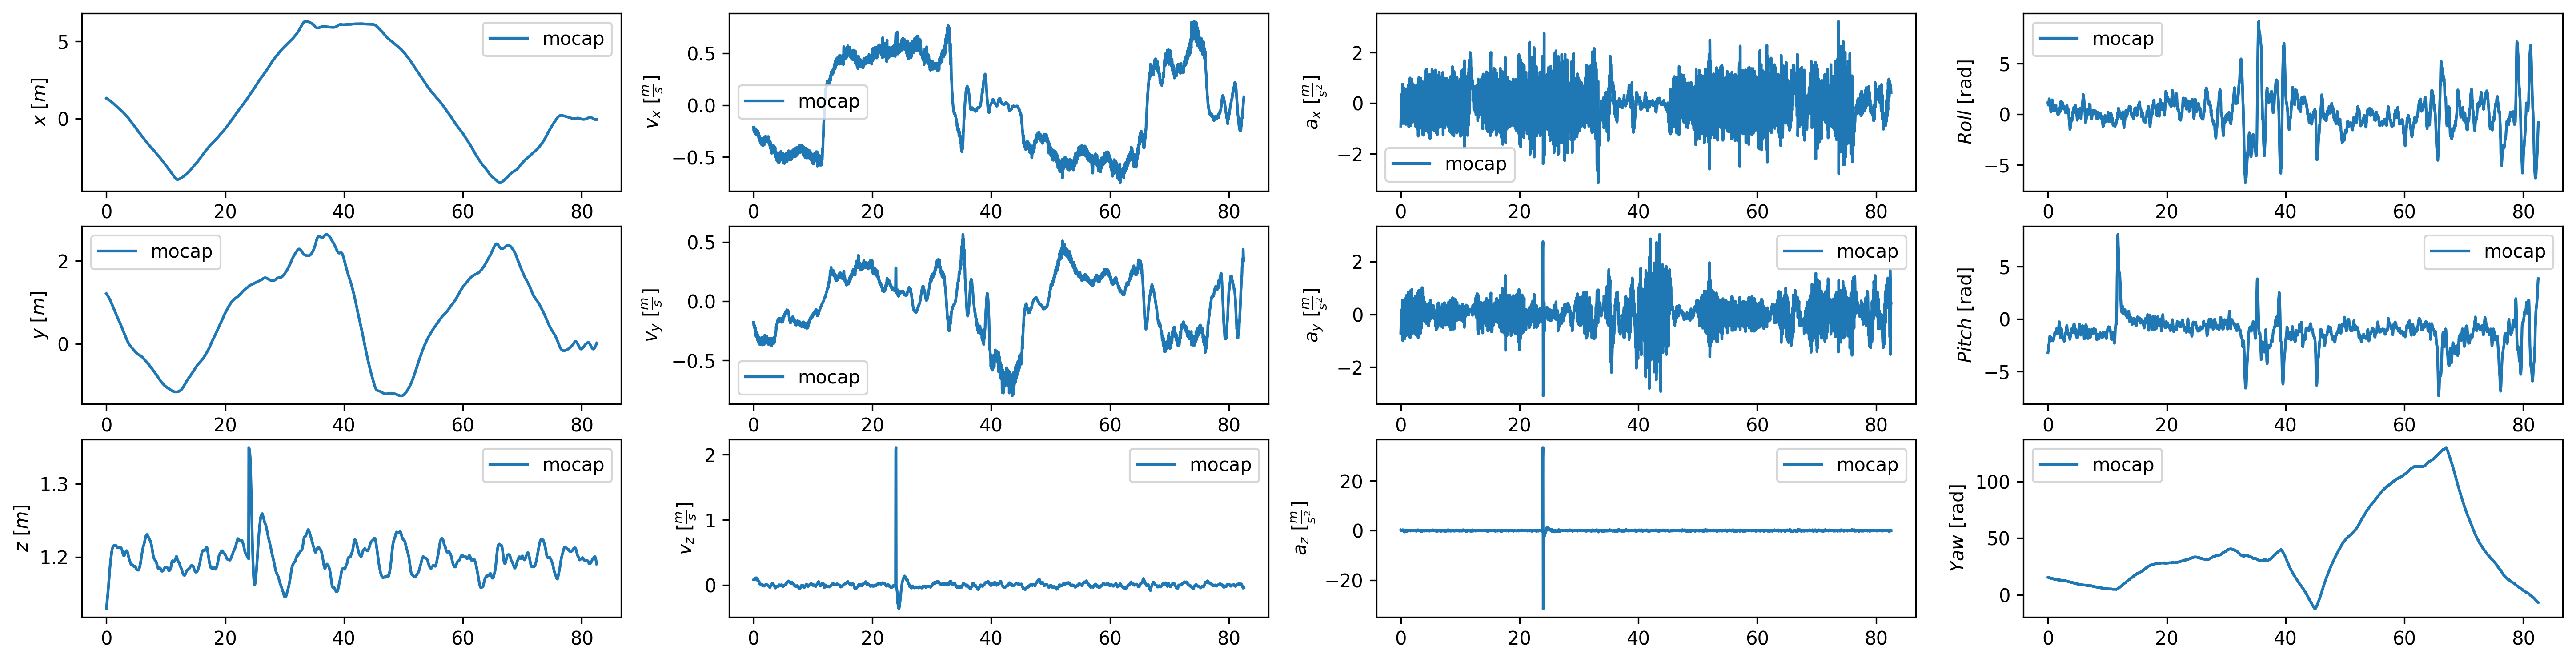

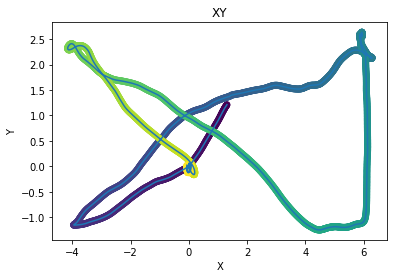

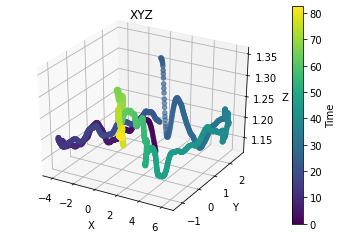

In [72]:
# plot the mocap data 
fig, ax = plt.subplots(3, 4, figsize=(3 * 8, 3 * 2), dpi=300)
# plot x
ax[0, 0].plot(mocap_time_shifted, mocap_X, label='mocap')
ax[0, 0].set_ylabel('$x$ [$m$]')
ax[0, 0].legend()
# plot y
ax[1, 0].plot(mocap_time_shifted, mocap_Y, label='mocap')
ax[1, 0].set_ylabel('$y$ [$m$]')
ax[1, 0].legend()
# plot z
ax[2, 0].plot(mocap_time_shifted, mocap_Z, label='mocap')
ax[2, 0].set_ylabel('$z$ [$m$]')
ax[2, 0].legend()
# plot x_dot
ax[0, 1].plot(mocap_time_shifted, mocap_X_dot, label='mocap')
ax[0, 1].set_ylabel(r'$v_x$ [$\frac{m}{s}$]')
ax[0, 1].legend()
# plot y_dot
ax[1, 1].plot(mocap_time_shifted, mocap_Y_dot, label='mocap')
ax[1, 1].set_ylabel(r'$v_y$ [$\frac{m}{s}$]')
ax[1, 1].legend()
# plot z_dot
ax[2, 1].plot(mocap_time_shifted, mocap_Z_dot, label='mocap')
ax[2, 1].set_ylabel(r'$v_z$ [$\frac{m}{s}$]')
ax[2, 1].legend()
# plot x_ddot
ax[0, 2].plot(mocap_time_shifted, mocap_X_ddot, label='mocap')
ax[0, 2].set_ylabel(r'$a_x$ [$\frac{m}{s^2}$]')
ax[0, 2].legend()
# plot y_ddot
ax[1, 2].plot(mocap_time_shifted, mocap_Y_ddot, label='mocap')
ax[1, 2].set_ylabel(r'$a_y$ [$\frac{m}{s^2}$]')
ax[1, 2].legend()
# plot z_ddot
ax[2, 2].plot(mocap_time_shifted, mocap_Z_ddot, label='mocap')
ax[2, 2].set_ylabel(r'$a_z$ [$\frac{m}{s^2}$]')
ax[2, 2].legend()
# plot Roll
ax[0, 3].plot(mocap_time_shifted, mocap_Roll, label='mocap')
ax[0, 3].set_ylabel('$Roll$ [rad]')
ax[0, 3].legend()
# plot Pitch
ax[1, 3].plot(mocap_time_shifted, mocap_Pitch, label='mocap')
ax[1, 3].set_ylabel('$Pitch$ [rad]')
ax[1, 3].legend()
# plot Yaw
ax[2, 3].plot(mocap_time_shifted, mocap_Yaw, label='mocap')
ax[2, 3].set_ylabel('$Yaw$ [rad]')
ax[2, 3].legend()
plt.show()

# x,y plot of the mocap data
plt.plot(mocap_X, mocap_Y)
plt.scatter(mocap_X, mocap_Y, label='start', c=mocap_time_shifted)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY')
plt.show()



# make 3d plot of XYZ with time as color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(mocap_X, mocap_Y, mocap_Z, c=mocap_time_shifted)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('XYZ')
plt.colorbar(sc, label='Time')
plt.show()

# body level velocities and acclerations

1.128542707489211 -3.2171560997137263 15.35368874474259


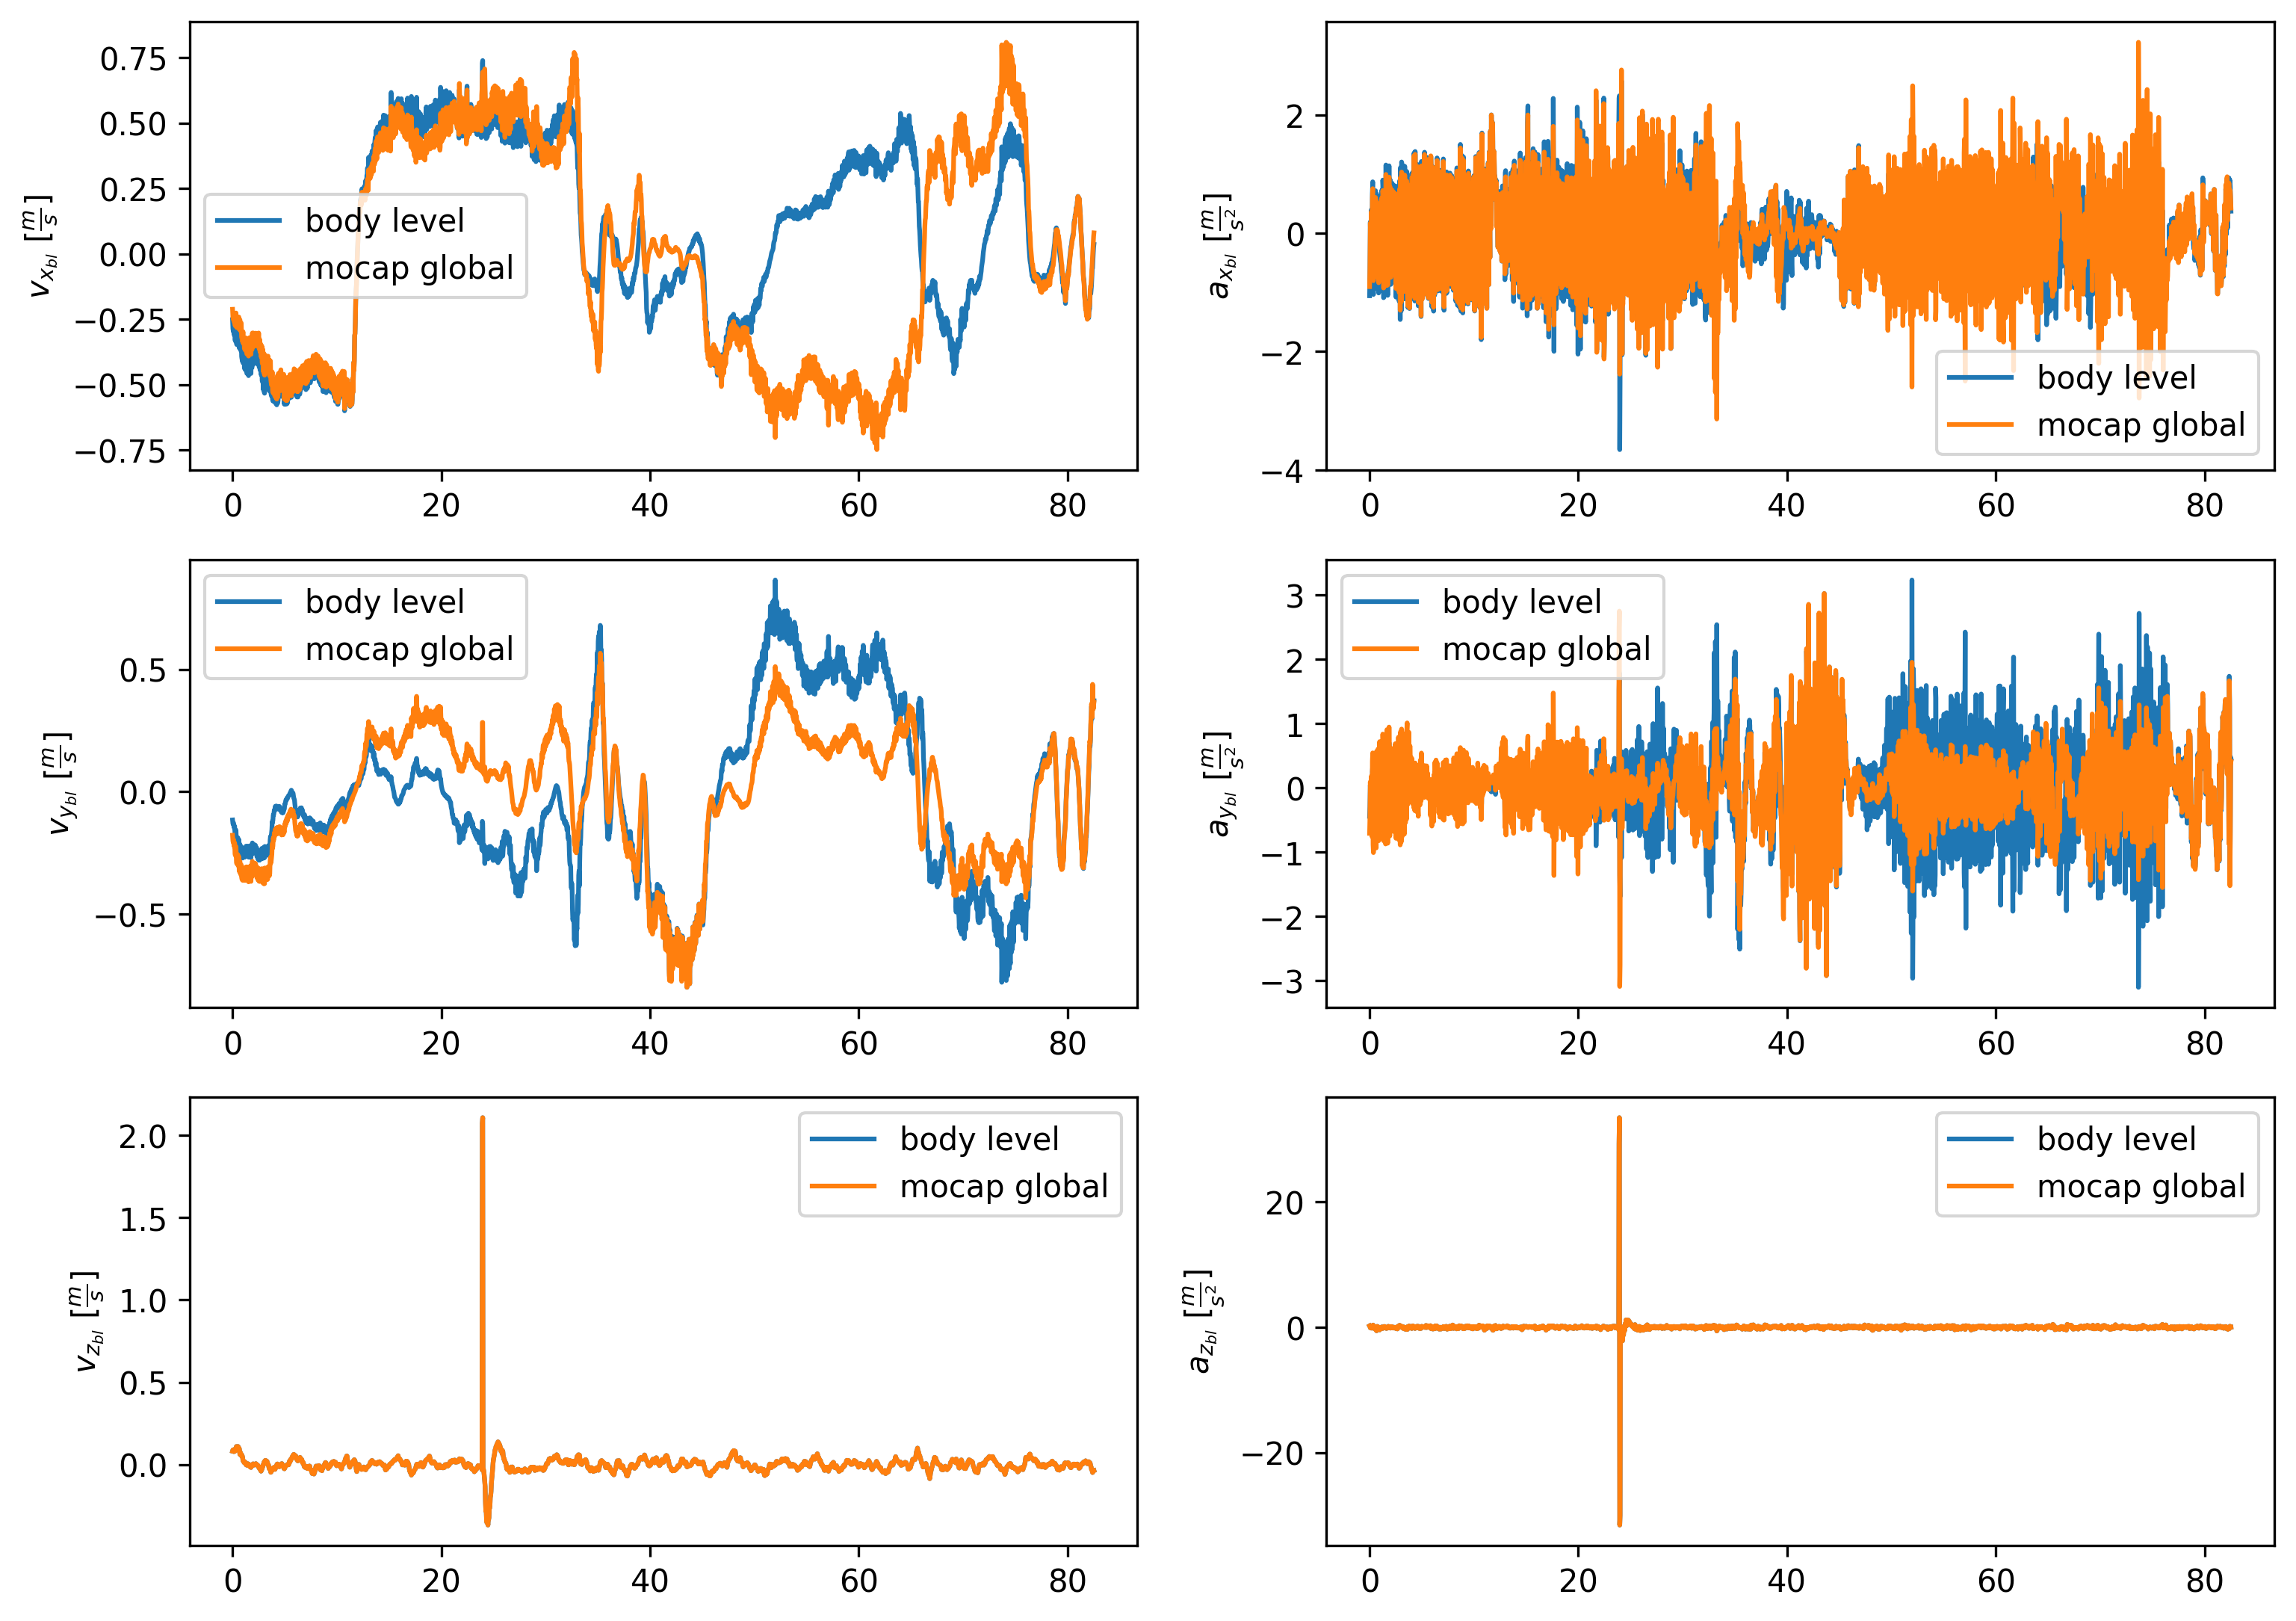

In [73]:
# R_G_BL (rotation from global to body level ) function that takes in roll, pitch, yaw and gives out the rotation matrix

def R_G_BL(roll, pitch, yaw):
    """
    Compute the rotation matrix from global frame to body-level frame.
    This only applies a yaw rotation (inverse of R_z) to align with the body-level frame.

    Args:
    roll  (float): Roll angle (phi) in radians.
    pitch (float): Pitch angle (theta) in radians.
    yaw   (float): Yaw angle (psi) in radians.

    Returns:
    numpy.ndarray: 3x3 rotation matrix from global to body-level frame.
    """
    R_z = np.array([[ np.cos(yaw), np.sin(yaw), 0],
                    [-np.sin(yaw), np.cos(yaw), 0],
                    [ 0, 0, 1]])

    return R_z  # This is R_z(-yaw), rotating global to body-level

    return R_G_BL
print(mocap_Roll[0], mocap_Pitch[0], mocap_Yaw[0])
# Rotate the velocity and acceleration from global to body level
mocap_bl_X_dot = []
mocap_bl_Y_dot = []
mocap_bl_Z_dot = []
mocap_bl_X_ddot = []
mocap_bl_Y_ddot = []
mocap_bl_Z_ddot = []

for i in range(len(mocap_Roll)):
    R_G_BL_i = R_G_BL(np.deg2rad(mocap_Roll[i]), np.deg2rad(mocap_Pitch[i]), np.deg2rad(mocap_Yaw[i]))
    
    # Velocity transformation
    velocity_vector = np.array([mocap_X_dot[i], mocap_Y_dot[i], mocap_Z_dot[i]])
    transformed_velocity = R_G_BL_i @ velocity_vector  # This returns a 3-element vector

    mocap_bl_X_dot.append(transformed_velocity[0])
    mocap_bl_Y_dot.append(transformed_velocity[1])
    mocap_bl_Z_dot.append(transformed_velocity[2])

    # Acceleration transformation
    acceleration_vector = np.array([mocap_X_ddot[i], mocap_Y_ddot[i], mocap_Z_ddot[i]])
    transformed_acceleration = R_G_BL_i @ acceleration_vector  # This returns a 3-element vector

    mocap_bl_X_ddot.append(transformed_acceleration[0])
    mocap_bl_Y_ddot.append(transformed_acceleration[1])
    mocap_bl_Z_ddot.append(transformed_acceleration[2])


# plot the body level velocities and accelerations
fig, ax = plt.subplots(3, 2, figsize=(3 * 4, 3 * 3), dpi=300)
# plot x_dot
ax[0, 0].plot(mocap_time_shifted, mocap_bl_X_dot, label='body level')
ax[0, 0].plot(mocap_time_shifted, mocap_X_dot, label='mocap global')
ax[0, 0].set_ylabel(r'$v_{x_{bl}}$ [$\frac{m}{s}$]')
ax[0, 0].legend()
# plot y_dot
ax[1, 0].plot(mocap_time_shifted, mocap_bl_Y_dot, label='body level')
ax[1, 0].plot(mocap_time_shifted, mocap_Y_dot, label='mocap global')
ax[1, 0].set_ylabel(r'$v_{y_{bl}}$ [$\frac{m}{s}$]')
ax[1, 0].legend()
# plot z_dot
ax[2, 0].plot(mocap_time_shifted, mocap_bl_Z_dot, label='body level')
ax[2, 0].plot(mocap_time_shifted, mocap_Z_dot, label='mocap global')
ax[2, 0].set_ylabel(r'$v_{z_{bl}}$ [$\frac{m}{s}$]')
ax[2, 0].legend()
# plot x_ddot
ax[0, 1].plot(mocap_time_shifted, mocap_bl_X_ddot, label='body level')
ax[0, 1].plot(mocap_time_shifted, mocap_X_ddot, label='mocap global')
ax[0, 1].set_ylabel(r'$a_{x_{bl}}$ [$\frac{m}{s^2}$]')
ax[0, 1].legend()
# plot y_ddot
ax[1, 1].plot(mocap_time_shifted, mocap_bl_Y_ddot, label='body level')
ax[1, 1].plot(mocap_time_shifted, mocap_Y_ddot, label='mocap global')
ax[1, 1].set_ylabel(r'$a_{y_{bl}}$ [$\frac{m}{s^2}$]')
ax[1, 1].legend()
# plot z_ddot
ax[2, 1].plot(mocap_time_shifted, mocap_bl_Z_ddot, label='body level')
ax[2, 1].plot(mocap_time_shifted, mocap_Z_ddot, label='mocap global')
ax[2, 1].set_ylabel(r'$a_{z_{bl}}$ [$\frac{m}{s^2}$]')
ax[2, 1].legend()
plt.show()


# IMU [Roll($\phi$),Pitch($\theta$),Yaw($\psi$)] + [$\omega_x$,$\omega_y$,$\omega_z$] + [$A_x$,$A_y$,$A_z$]

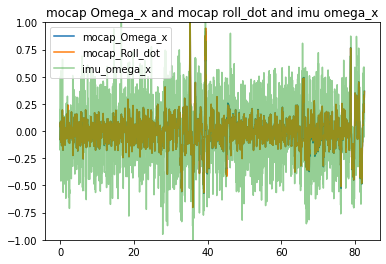

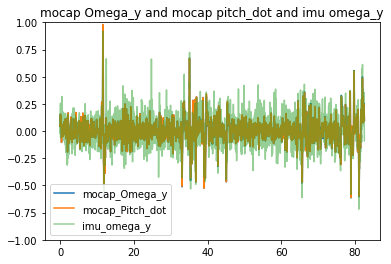

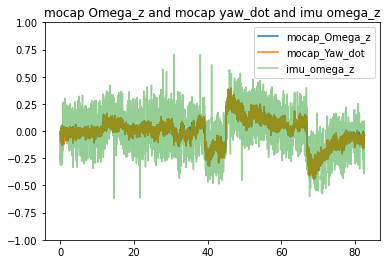

In [74]:
imu_time = data['mavros/imu/data']['rosbagTimestamp']/1e9
imu_time_shifted = imu_time - imu_time[0]
imu_Roll, imu_Pitch, imu_Yaw = [], [], []
for i in range(len(data['mavros/imu/data'])):
    R, P, Y = quaternion_to_euler(data['mavros/imu/data']['x'][i],
                                  data['mavros/imu/data']['y'][i],
                                  data['mavros/imu/data']['z'][i],
                                  data['mavros/imu/data']['w'][i])
    imu_Roll.append(np.radians(R))
    imu_Pitch.append(np.radians(P))
    imu_Yaw.append(np.radians(Y))

imu_omega_x = data['mavros/imu/data']['x.1']
imu_omega_y = data['mavros/imu/data']['y.1']
imu_omega_z = data['mavros/imu/data']['z.1']

# function that goes from omega_dot to phi_dot, theta_dot, psi_dot

def omega_to_euler_dot(omega_x, omega_y, omega_z, phi, theta, psi):
    """
    Converts angular velocity components (omega_x, omega_y, omega_z)
    to Euler angle rates (phi_dot, theta_dot, psi_dot).

    input: omega_x, omega_y, omega_z, phi, theta
    output: phi_dot, theta_dot, psi_dot
    """
    phi_dot = omega_x + omega_y * np.tan(theta) * np.sin(phi) + omega_z * np.tan(theta) * np.cos(phi)
    theta_dot = omega_y * np.cos(phi) - omega_z * np.sin(phi)
    psi_dot = omega_y * np.sin(phi) / np.cos(theta) + omega_z * np.cos(phi) / np.cos(theta)

    return phi_dot, theta_dot, psi_dot

def euler_dot_to_omega(phi_dot, theta_dot, psi_dot, phi, theta, psi):
    """
    Converts Euler angle rates (phi_dot, theta_dot, psi_dot)
    to angular velocity components (omega_x, omega_y, omega_z).

    input: phi_dot, theta_dot, psi_dot, phi, theta
    output: omega_x, omega_y, omega_z
    """
    omega_x = phi_dot - psi_dot * np.sin(theta)
    omega_y = theta_dot * np.cos(phi) + psi_dot * np.cos(theta) * np.sin(phi)
    omega_z = -theta_dot * np.sin(phi) + psi_dot * np.cos(theta) * np.cos(phi)

    return omega_x, omega_y, omega_z

imu_phi_dot, imu_theta_dot, imu_psi_dot = [], [], []
for i in range(len(data['mavros/imu/data'])):
    phi_dot, theta_dot, psi_dot = omega_to_euler_dot(imu_omega_x[i],
                                                         imu_omega_y[i],
                                                         imu_omega_z[i],
                                                         imu_Roll[i],
                                                         imu_Pitch[i],
                                                         imu_Yaw[i])
    imu_phi_dot.append(phi_dot)
    imu_theta_dot.append(theta_dot)
    imu_psi_dot.append(psi_dot)
# using mocap data get Omega_x, Omega_y, Omega_z
mocap_Omega_x, mocap_Omega_y, mocap_Omega_z = [], [], []
for i in range(len(data['mavros/local_position/pose'])):
    omega_x, omega_y, omega_z = euler_dot_to_omega(np.gradient(np.deg2rad(mocap_Roll), mocap_time)[i],
                                                    np.gradient(np.deg2rad(mocap_Pitch), mocap_time)[i],
                                                    np.gradient(np.deg2rad(mocap_Yaw), mocap_time)[i],
                                                    np.deg2rad(mocap_Roll[i]),
                                                    np.deg2rad(mocap_Pitch[i]),
                                                    np.deg2rad(mocap_Yaw[i]))
    mocap_Omega_x.append(omega_x)
    mocap_Omega_y.append(omega_y)
    mocap_Omega_z.append(omega_z)

                                                   

# function that goes from phi_dot, theta_dot, psi_dot to omega_x, omega_y, omega_z
def euler_dot_to_omega_dot(phi_dot, theta_dot, psi_dot, phi, theta):
    """
    input: phi_dot, theta_dot, psi_dot, phi, theta
    output: omega_x, omega_y, omega_z
    """
    omega_x = phi_dot - psi_dot * np.sin(theta)
    omega_y = theta_dot * np.cos(phi) + psi_dot * np.cos(theta) * np.sin(phi)
    omega_z = psi_dot * np.cos(theta) * np.cos(phi) - theta_dot * np.sin(phi)
    return omega_x, omega_y, omega_z

# take the gradient of imu_roll, imu_pitch, imu_yaw to get the angular velocities
imu_Roll_dot = np.gradient(imu_Roll, imu_time)
imu_Pitch_dot = np.gradient(imu_Pitch, imu_time)
imu_Yaw_dot = np.gradient(imu_Yaw, imu_time)



plt.plot(mocap_time_shifted, mocap_Omega_x, label='mocap_Omega_x')
plt.plot(mocap_time_shifted, np.gradient(np.deg2rad(mocap_Roll), mocap_time), label='mocap_Roll_dot')
plt.plot(imu_time_shifted, imu_omega_x, label='imu_omega_x',alpha=.5)
plt.title('mocap Omega_x and mocap roll_dot and imu omega_x')
plt.ylim(-1,1)
plt.legend()
plt.show()

plt.plot(mocap_time_shifted, mocap_Omega_y, label='mocap_Omega_y')
plt.plot(mocap_time_shifted, np.gradient(np.deg2rad(mocap_Pitch), mocap_time), label='mocap_Pitch_dot')
plt.plot(imu_time_shifted, imu_omega_y, label='imu_omega_y',alpha=.5)
plt.title('mocap Omega_y and mocap pitch_dot and imu omega_y')
plt.ylim(-1,1)
plt.legend()
plt.show()

plt.plot(mocap_time_shifted, mocap_Omega_z, label='mocap_Omega_z')
plt.plot(mocap_time_shifted, np.gradient(np.deg2rad(mocap_Yaw), mocap_time), label='mocap_Yaw_dot')
plt.plot(imu_time_shifted, imu_omega_z, label='imu_omega_z',alpha=.5)
plt.title('mocap Omega_z and mocap yaw_dot and imu omega_z')
plt.ylim(-1,1)
plt.legend()
plt.show()



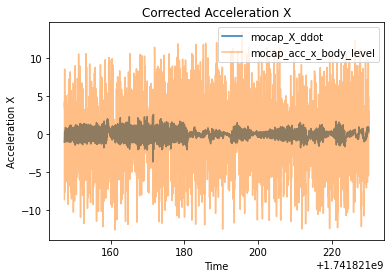

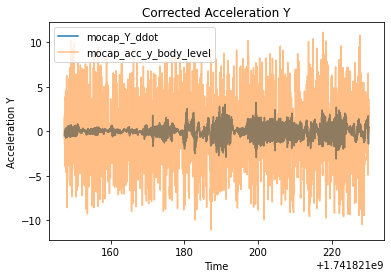

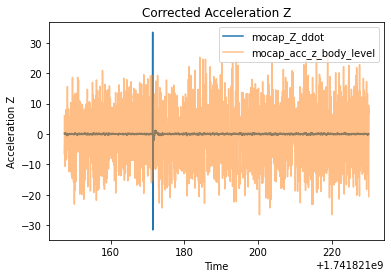

In [75]:
g = 9.81  # Gravitational acceleration (m/s^2)

# Function to compute the rotation matrix from roll, pitch, yaw
def rotation_matrix_from_euler(roll, pitch, yaw):
    """
    Creates a rotation matrix from roll, pitch, yaw angles (in radians).
    """
    # Compute rotation matrices for roll, pitch, and yaw
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_yaw = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    # Combine the rotation matrices (Z * Y * X)
    R = R_yaw @ R_pitch @ R_roll
    return R

# Function to remove gravity from linear acceleration
def remove_gravity_from_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Removes the gravity component from the linear acceleration in the body frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_corrected, acc_y_corrected, acc_z_corrected: numpy arrays
        Corrected linear accelerations with gravity removed along the x, y, and z axes.
    """
    # Initialize corrected acceleration arrays
    acc_x_corrected = np.zeros_like(acc_x)
    acc_y_corrected = np.zeros_like(acc_y)
    acc_z_corrected = np.zeros_like(acc_z)
    
    # Gravity vector in the world frame (assume gravity points along the Z-axis)
    gravity_world = np.array([0, 0, g])
    
    # Loop over each time step and correct the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Transform gravity vector from world frame to body frame
        gravity_body = R.T @ gravity_world  # Transpose R to rotate from world to body
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Subtract gravity from the body-frame acceleration
        acc_corrected = acc_body - gravity_body
        
        # Store the corrected acceleration
        acc_x_corrected[i] = acc_corrected[0]
        acc_y_corrected[i] = acc_corrected[1]
        acc_z_corrected[i] = acc_corrected[2]
    
    return acc_x_corrected, acc_y_corrected, acc_z_corrected

# Remove gravity from the linear acceleration
imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected = remove_gravity_from_acceleration(
    data['mavros/imu/data']['x.2'],
    data['mavros/imu/data']['y.2'],
    data['mavros/imu/data']['z.2'],
    imu_Roll, imu_Pitch, imu_Yaw
)

# rotate the acceleration data to the world frame
def rotate_acceleration_to_world_frame(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Rotates the linear acceleration from the body frame to the world frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_world, acc_y_world, acc_z_world: numpy arrays
        Linear acceleration in the world frame along the x, y, and z axes.
    """
    # Initialize world-frame acceleration arrays
    acc_x_world = np.zeros_like(acc_x)
    acc_y_world = np.zeros_like(acc_y)
    acc_z_world = np.zeros_like(acc_z)
    
    # Loop over each time step and rotate the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Rotate the body-frame acceleration to the world frame
        acc_world = R @ acc_body
        
        # Store the world-frame acceleration
        acc_x_world[i] = acc_world[0]
        acc_y_world[i] = acc_world[1]
        acc_z_world[i] = acc_world[2]
    
    return acc_x_world, acc_y_world, acc_z_world

# Rotate the acceleration data to the world frame
imu_acc_x_corrected_world, imu_acc_y_corrected_world, imu_acc_z_corrected_world = rotate_acceleration_to_world_frame(
    imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected, imu_Roll, imu_Pitch, imu_Yaw
)


# creat rotation from body to body level frame ie roll and pitch
def rotation_matrix_from_roll_pitch(roll, pitch):
    """
    Creates a rotation matrix from roll and pitch angles (in radians).
    """
    # Compute rotation matrices for roll and pitch
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    # Combine the rotation matrices
    R_b_bl = R_pitch @ R_roll
    return R_b_bl

# rotate the acceleration from the body frame to the body level frame
def rotate_acceleration_to_body_level_frame(acc_x, acc_y, acc_z, roll, pitch):
    """
    Rotates the linear acceleration from the body frame to the body level frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch: numpy arrays
        Arrays of roll and pitch angles (in radians).
    
    Returns:
    acc_x_body_level, acc_y_body_level, acc_z_body_level: numpy arrays
        Linear acceleration in the body level frame along the x, y, and z axes.
    """
    # Initialize body-level acceleration arrays
    acc_x_body_level = np.zeros_like(acc_x)
    acc_y_body_level = np.zeros_like(acc_y)
    acc_z_body_level = np.zeros_like(acc_z)
    
    # Loop over each time step and rotate the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch)
        R = rotation_matrix_from_roll_pitch(roll[i], pitch[i])
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Rotate the body-frame acceleration to the body level frame
        acc_body_level = R @ acc_body
        
        # Store the body-level acceleration
        acc_x_body_level[i] = acc_body_level[0]
        acc_y_body_level[i] = acc_body_level[1]
        acc_z_body_level[i] = acc_body_level[2]
    
    return acc_x_body_level, acc_y_body_level, acc_z_body_level

acc_x_body_level, acc_y_body_level, acc_z_body_level = rotate_acceleration_to_body_level_frame(
    imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected, imu_Roll, imu_Pitch
)


# plt.plot(imu_time, imu_acc_x_corrected_world,label='imu_acc_x_corrected')
plt.plot(mocap_time, mocap_bl_X_ddot,label='mocap_X_ddot')
plt.plot(imu_time, acc_x_body_level,label='mocap_acc_x_body_level',alpha=0.5)
# plt.plot(mocap_time, mocap_X_ddot,label='mocap_X_ddot',alpha=0.5)
plt.title('Corrected Acceleration X')
plt.xlabel('Time')
plt.ylabel('Acceleration X')
plt.legend()
plt.show()

# plt.plot(imu_time, imu_acc_y_corrected_world,label='imu_acc_y_corrected')
plt.plot(mocap_time, mocap_bl_Y_ddot,label='mocap_Y_ddot')
plt.plot(imu_time, acc_y_body_level,label='mocap_acc_y_body_level',alpha=0.5)
# plt.plot(mocap_time, mocap_Y_ddot,label='mocap_Y_ddot',alpha=0.5)
plt.title('Corrected Acceleration Y')
plt.xlabel('Time')
plt.ylabel('Acceleration Y')
plt.legend()
plt.show()

# plt.plot(imu_time, imu_acc_z_corrected_world,label='imu_acc_z_corrected')
plt.plot(mocap_time, mocap_bl_Z_ddot,label='mocap_Z_ddot')
plt.plot(imu_time, acc_z_body_level,label='mocap_acc_z_body_level',alpha=0.5)
# plt.plot(mocap_time, mocap_Z_ddot,label='mocap_Z_ddot',alpha=0.5)
plt.title('Corrected Acceleration Z')
plt.xlabel('Time')
plt.ylabel('Acceleration Z')
plt.legend()
plt.show()


# optic flow (body level) - camera data

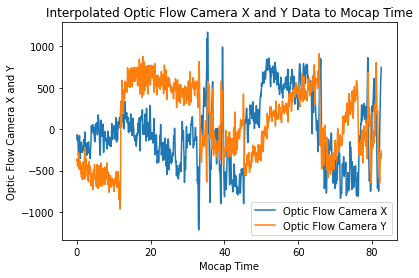

In [76]:
optic_flow_camera_x_time = data['optic_flow/camera/mean/x']['rosbagTimestamp']/1e9
optic_flow_camera_y_time = data['optic_flow/camera/mean/y']['rosbagTimestamp']/1e9
optic_flow_camera_x = data['optic_flow/camera/mean/x']['data']
optic_flow_camera_y = data['optic_flow/camera/mean/y']['data']

# interpolate optic flow camera data to mocap time
optic_flow_camera_x_mocap_interp = interpolate_data(optic_flow_camera_x_time, optic_flow_camera_x, mocap_time)
optic_flow_camera_y_mocap_interp = interpolate_data(optic_flow_camera_y_time, optic_flow_camera_y, mocap_time)

optic_flow_camera_x_mocap_interp=np.multiply(optic_flow_camera_x_mocap_interp, mocap_Z)
optic_flow_camera_y_mocap_interp=np.multiply(optic_flow_camera_y_mocap_interp, mocap_Z)

optic_flow_camera_x_mocap_interp[np.abs(optic_flow_camera_x_mocap_interp - np.median(optic_flow_camera_x_mocap_interp)) > 3 * np.std(optic_flow_camera_x_mocap_interp)] = np.median(optic_flow_camera_x_mocap_interp)
optic_flow_camera_y_mocap_interp[np.abs(optic_flow_camera_y_mocap_interp - np.median(optic_flow_camera_y_mocap_interp)) > 3 * np.std(optic_flow_camera_y_mocap_interp)] = np.median(optic_flow_camera_y_mocap_interp)

# Plot the interpolated data
plt.plot(mocap_time_shifted, optic_flow_camera_x_mocap_interp, label="Optic Flow Camera X")
plt.plot(mocap_time_shifted, optic_flow_camera_y_mocap_interp, label="Optic Flow Camera Y")
plt.title('Interpolated Optic Flow Camera X and Y Data to Mocap Time')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.legend()
plt.show()

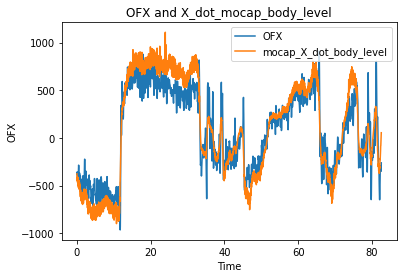

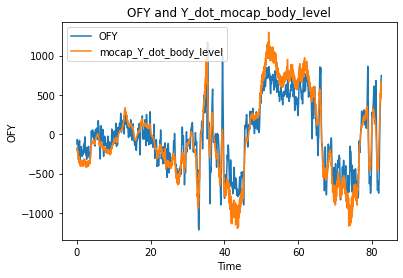

In [77]:
OFX=optic_flow_camera_x_mocap_interp.copy()
OFY=optic_flow_camera_y_mocap_interp.copy()

# apply a yaw rotation to the optic flow data using matrix multiplication
def rotate_optic_flow(OFX, OFY):
    """
    input: OFX, OFY
    output: rotated OFX, OFY
    """
    # apply a 180 degree rotation about x axis using the rotation matrix
    OFX = OFX*1
    OFY = OFY*np.cos(np.pi)

    # un yawing and rotating by 90 degrees
    OFY_rot = np.sin(np.pi/2) * OFX + np.cos(np.pi/2) * OFY
    OFX_rot = np.cos(np.pi/2) * OFX - np.sin(np.pi/2) * OFY
    return OFX_rot, OFY_rot


OFX_rot, OFY_rot = rotate_optic_flow(OFX, OFY)

plt.plot(mocap_time_shifted, OFX_rot,label='OFX')
plt.plot(mocap_time_shifted, np.multiply(mocap_bl_X_dot,1500),label='mocap_X_dot_body_level')
plt.title('OFX and X_dot_mocap_body_level')
plt.xlabel('Time')
plt.ylabel('OFX')
plt.legend()
plt.show()

plt.plot(mocap_time_shifted, OFY_rot,label='OFY')
plt.plot(mocap_time_shifted, np.multiply(mocap_bl_Y_dot,1500),label='mocap_Y_dot_body_level')
plt.title('OFY and Y_dot_mocap_body_level')
plt.xlabel('Time')
plt.ylabel('OFY')
plt.legend()
plt.show()


2477
Scalar (meters/pixel) X: 0.0007856430266327901
Scalar (meters/pixel) Y: 0.0007661464760117649


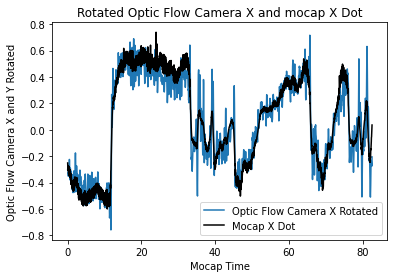

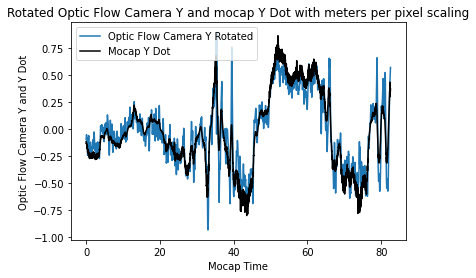

In [78]:
# Reshape the optic flow data to fit the linear regression model
OFX_rot_temp = np.array(OFX_rot)[:int(len(optic_flow_camera_x_mocap_interp)/1)].reshape(-1, 1)
OFY_rot_temp = np.array(OFY_rot)[:int(len(optic_flow_camera_x_mocap_interp)/1)].reshape(-1, 1)
print(len(OFY))
# Perform linear regression
modelX = LinearRegression()
modelX.fit(OFX_rot_temp, mocap_bl_X_dot[:int(len(optic_flow_camera_x_mocap_interp)/1)])

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_X = modelX.coef_[0]
optic_flow_scalar_X = meters_per_pixel_X.copy()
print(f"Scalar (meters/pixel) X: {meters_per_pixel_X}")

modelY = LinearRegression()
modelY.fit(OFY_rot_temp, mocap_bl_Y_dot[:int(len(optic_flow_camera_x_mocap_interp)/1)])

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_Y = modelY.coef_[0]
optic_flow_scalar_Y = meters_per_pixel_Y.copy()
print(f"Scalar (meters/pixel) Y: {meters_per_pixel_Y}")

# Plot the rotated optic flow data
plt.plot(mocap_time_shifted, np.multiply(OFX_rot,meters_per_pixel_X), label="Optic Flow Camera X Rotated")
plt.plot(mocap_time_shifted,np.multiply(mocap_bl_X_dot,1), label="Mocap X Dot",color='black')
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time_shifted, np.multiply(OFY_rot,meters_per_pixel_Y), label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time_shifted,np.multiply(mocap_bl_Y_dot,1), label="Mocap Y Dot",color='black')
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot with meters per pixel scaling')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()

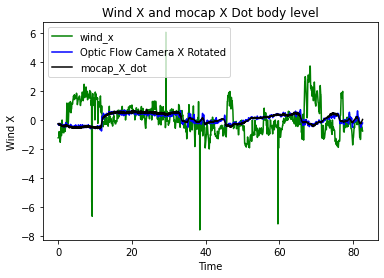

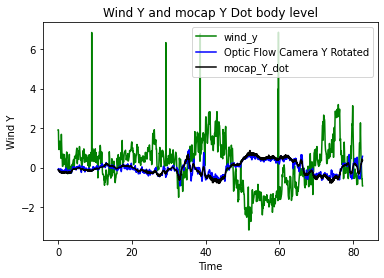

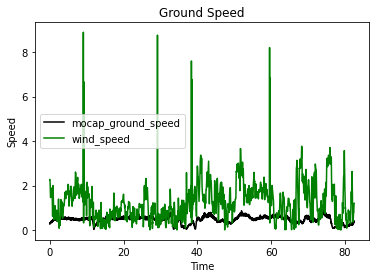

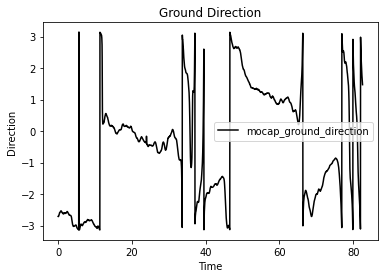

In [ ]:
wind_time = data['trisonica']['rosbagTimestamp']/1e9
wind_time_shifted = wind_time - wind_time[0]
wind_x = data['trisonica']['westeast']
wind_y = -1*data['trisonica']['northsouth']

# interpolate wind data to mocap time
wind_x_mocap_interp = interpolate_data(wind_time, wind_x, mocap_time)
wind_y_mocap_interp = interpolate_data(wind_time, wind_y, mocap_time)

# # filter out large spikes in the wind data
if FLAG_FILE == "con_vel" or FLAG_FILE == "con_vel_con_yaw":
    wind_x_mocap_interp[np.abs(wind_x_mocap_interp - np.median(wind_x_mocap_interp)) > 3 * np.std(wind_x_mocap_interp)] = np.median(wind_x_mocap_interp)
    wind_y_mocap_interp[np.abs(wind_y_mocap_interp - np.median(wind_y_mocap_interp)) > 3 * np.std(wind_y_mocap_interp)] = np.median(wind_y_mocap_interp)


plt.plot(mocap_time_shifted, wind_x_mocap_interp,label='wind_x',color='green')
# plt.plot(wind_time_shifted, wind_x,label='wind_x',color='green')
# plt.plot(mocap_time_shifted, np.multiply(OFX_rot,meters_per_pixel_X), label="Optic Flow Camera X Rotated",color='blue')
plt.plot(mocap_time_shifted, mocap_bl_X_dot,label='mocap_X_dot',color='black')
plt.title('Wind X and mocap X Dot body level')
plt.xlabel('Time')
plt.ylabel('Wind X')
plt.legend()
plt.show()

plt.plot(mocap_time_shifted, wind_y_mocap_interp,label='wind_y',color='green')
# plt.plot(mocap_time_shifted, np.multiply(OFY_rot,meters_per_pixel_Y), label="Optic Flow Camera Y Rotated",color='blue')
plt.plot(mocap_time_shifted, mocap_bl_Y_dot,label='mocap_Y_dot',color='black')
plt.title('Wind Y and mocap Y Dot body level')
plt.xlabel('Time')
plt.ylabel('Wind Y')
plt.legend()
plt.show()

# mocap groung speed and direction
mocap_ground_speed = np.sqrt(np.square(mocap_bl_X_dot) + np.square(mocap_bl_Y_dot))
mocap_ground_direction = np.arctan2(mocap_bl_Y_dot, mocap_bl_X_dot)
wind_ground_speed = np.sqrt(np.square(wind_x_mocap_interp) + np.square(wind_y_mocap_interp))
wind_ground_direction = np.arctan2(wind_y_mocap_interp, wind_x_mocap_interp)

# plt.plot(mocap_time_shifted, mocap_ground_speed,label='mocap_ground_speed',color='black')
# plt.plot(mocap_time_shifted, wind_ground_speed,label='wind_speed',color='green')
# plt.title('Ground Speed')
# plt.xlabel('Time')
# plt.ylabel('Speed')
# plt.legend()
# plt.show()

# plt.plot(mocap_time_shifted, mocap_ground_direction,label='mocap_ground_direction',color='black')
# # plt.plot(mocap_time_shifted, wind_ground_direction,label='wind_direction',color='green')
# plt.title('Ground Direction')
# plt.xlabel('Time')
# plt.ylabel('Direction')
# plt.legend()
# plt.show()


Scalar X: -0.17270749753583464
Scalar Y: -0.226512607863543


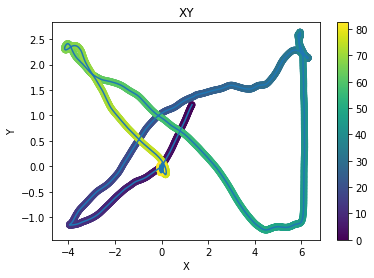

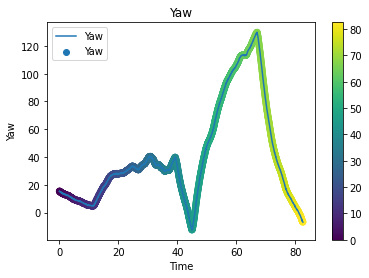

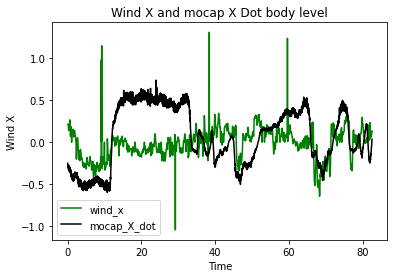

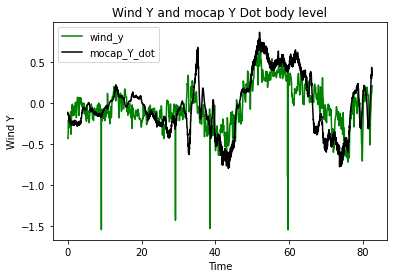

In [125]:

if FLAG_FILE == 'neg_X':
    start_int_x = 0
    stop_int_x = 1/4
    start_int_y = 0
    stop_int_y = 4/4
elif FLAG_FILE == 'con_vel':
    stop_int_x = 1/4
    start_int_y = 1/4
    stop_int_y = 2/4
elif FLAG_FILE == 'con_vel_con_yaw':
    start_int_x = 0/4
    stop_int_x = 4/4
    start_int_y = 2/4
    stop_int_y = 3/4

wind_body_level_x, wind_body_level_y =np.array(wind_x_mocap_interp).reshape(-1, 1), np.array(wind_y_mocap_interp).reshape(-1, 1)

wind_body_level_x_temp, wind_body_level_y_temp =np.array(wind_x_mocap_interp)[int(len(wind_x_mocap_interp)*start_int_x):int(len(wind_x_mocap_interp)*stop_int_x)].reshape(-1, 1), np.array(wind_y_mocap_interp).reshape(-1, 1)

wind_body_level_mag_temp = np.array(wind_ground_speed).reshape(-1, 1)

#perform linear regression on the wind data
model_wind_x = LinearRegression()
model_wind_x.fit(wind_body_level_x_temp, mocap_bl_X_dot[int(len(wind_x_mocap_interp)*start_int_x):int(len(wind_x_mocap_interp)*stop_int_x)])

# The slope of the linear regression gives you the scalar
wind_scalar_x = model_wind_x.coef_[0]
# print(model_wind_x.coef_)
print(f"Scalar X: {wind_scalar_x}")

model_wind_y = LinearRegression()
model_wind_y.fit(wind_body_level_y_temp, mocap_bl_Y_dot)

# The slope of the linear regression gives you the scalar
wind_scalar_y = model_wind_y.coef_[0]
print(f"Scalar Y: {wind_scalar_y}")

model_wind_mag = LinearRegression()
model_wind_mag.fit(wind_body_level_mag_temp, mocap_ground_speed)

# The slope of the linear regression gives you the scalar
wind_scalar_mag = model_wind_mag.coef_[0]
# print(f"Scalar (unitless) Mag: {wind_scalar_mag}")


#mocap xy plot
plt.plot(mocap_X, mocap_Y,label='mocap')
plt.scatter(mocap_X, mocap_Y, label='start', c=mocap_time_shifted)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY')
plt.colorbar()
plt.show()

#plot mocap yaw
plt.plot(mocap_time_shifted, mocap_Yaw,label='Yaw')
plt.scatter(mocap_time_shifted, mocap_Yaw, label='Yaw', c=mocap_time_shifted)
plt.title('Yaw')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.legend()
plt.colorbar()
plt.show()

plt.plot(mocap_time_shifted, np.multiply(wind_body_level_x,wind_scalar_x),label='wind_x',color='green')
plt.plot(mocap_time_shifted, mocap_bl_X_dot,label='mocap_X_dot',color='black')
plt.title('Wind X and mocap X Dot body level')
plt.xlabel('Time')
plt.ylabel('Wind X')
# plt.ylim(-1.5,1.5)
plt.legend()
plt.show()

plt.plot(mocap_time_shifted, np.multiply(wind_body_level_y,wind_scalar_y),label='wind_y',color='green')
plt.plot(mocap_time_shifted, mocap_bl_Y_dot,label='mocap_Y_dot',color='black')
plt.title('Wind Y and mocap Y Dot body level')
plt.xlabel('Time')
plt.ylabel('Wind Y')
plt.legend()
plt.show()

# plt.plot(mocap_time_shifted, np.multiply(wind_ground_speed,wind_scalar_mag),label='wind_speed')
# plt.plot(mocap_time_shifted, mocap_ground_speed,label='mocap_ground_speed')
# plt.title('Ground Speed')
# plt.xlabel('Time')
# plt.ylabel('Speed')
# plt.legend()
# plt.show()


# RC Out ~ PWM

In [101]:
data['mavros/rc/out']
# split the data in header "channels" into individual columns named PWM1, PWM2, PWM3, PWM4 (only take the first 4 channels) each colum should be a float not a string
rc_time = data['mavros/rc/out']['rosbagTimestamp']/1e9
rc_time_shifted = rc_time - rc_time[0]
rc_channels = data['mavros/rc/out']['channels']
rc_channels = rc_channels.str.split(',', expand=True)
# remove "[" from the first column
rc_channels[0] = rc_channels[0].str.replace('[','')
rc_channels = rc_channels.iloc[:, :4]
rc_channels = rc_channels.astype(float)
PX4_1 = rc_channels[0]
PX4_2 = rc_channels[1]
PX4_3 = rc_channels[2]
PX4_4 = rc_channels[3]



/tmp/ipykernel_1855763/934606966.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  rc_channels[0] = rc_channels[0].str.replace('[','')


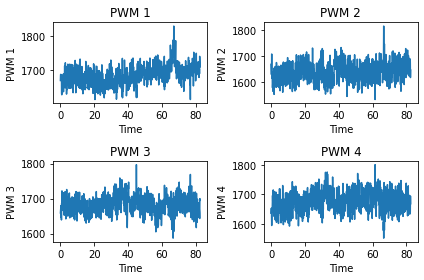

In [102]:
# pwm_1 = PX4_3
# pwm_2 = PX4_1
# pwm_3 = PX4_4
# pwm_4 = PX4_2

pwm_1 = PX4_1
pwm_2 = PX4_2
pwm_3 = PX4_3
pwm_4 = PX4_4
# 2x2 plot of the pwm data
plt.subplot(2, 2, 1)
plt.plot(rc_time_shifted, pwm_1)
plt.title('PWM 1')
plt.xlabel('Time')
plt.ylabel('PWM 1')

plt.subplot(2, 2, 2)
plt.plot(rc_time_shifted, pwm_2)
plt.title('PWM 2')
plt.xlabel('Time')
plt.ylabel('PWM 2')

plt.subplot(2, 2, 3)
plt.plot(rc_time_shifted, pwm_3)
plt.title('PWM 3')
plt.xlabel('Time')
plt.ylabel('PWM 3')

plt.subplot(2, 2, 4)
plt.plot(rc_time_shifted, pwm_4)
plt.title('PWM 4')
plt.xlabel('Time')
plt.ylabel('PWM 4')

plt.tight_layout()
plt.show()

# Get the final values fir all the measured data

## since Optic Flow is the fastes we will interpolate to that

### Mocap Final

In [103]:
X_TRUE = interpolate_data(mocap_time, mocap_X, optic_flow_camera_x_time)
X_DOT_G_TRUE = interpolate_data(mocap_time, mocap_X_dot, optic_flow_camera_x_time)
X_DOT_BL_TRUE = interpolate_data(mocap_time, mocap_bl_X_dot, optic_flow_camera_x_time)
Y_TRUE = interpolate_data(mocap_time, mocap_Y, optic_flow_camera_x_time)
Y_DOT_G_TRUE = interpolate_data(mocap_time, mocap_Y_dot, optic_flow_camera_x_time)
Y_DOT_BL_TRUE = interpolate_data(mocap_time, mocap_bl_Y_dot, optic_flow_camera_x_time)
Z_TRUE = interpolate_data(mocap_time, mocap_Z, optic_flow_camera_x_time)
Z_DOT_G_TRUE = interpolate_data(mocap_time, mocap_Z_dot, optic_flow_camera_x_time)
Z_DOT_BL_TRUE = interpolate_data(mocap_time, mocap_bl_Z_dot, optic_flow_camera_x_time)
Roll_TRUE = interpolate_data(mocap_time, mocap_Roll, optic_flow_camera_x_time)
Pitch_TRUE = interpolate_data(mocap_time, mocap_Pitch, optic_flow_camera_x_time)
Yaw_TRUE = interpolate_data(mocap_time, mocap_Yaw, optic_flow_camera_x_time)

### IMU Final

In [104]:
IMU_ROLL = interpolate_data(imu_time, imu_Roll, optic_flow_camera_x_time)
IMU_PITCH = interpolate_data(imu_time, imu_Pitch, optic_flow_camera_x_time)
IMU_YAW = interpolate_data(imu_time, imu_Yaw, optic_flow_camera_x_time)
IMU_ROLL_DOT = interpolate_data(imu_time, imu_Roll_dot, optic_flow_camera_x_time)
IMU_PITCH_DOT = interpolate_data(imu_time, imu_Pitch_dot, optic_flow_camera_x_time)
IMU_YAW_DOT = interpolate_data(imu_time, imu_Yaw_dot, optic_flow_camera_x_time)
IMU_OMEGA_X = interpolate_data(imu_time, imu_omega_x, optic_flow_camera_x_time)
IMU_OMEGA_Y = interpolate_data(imu_time, imu_omega_y, optic_flow_camera_x_time)
IMU_OMEGA_Z = interpolate_data(imu_time, imu_omega_z, optic_flow_camera_x_time)
IMU_ACC_BL_X = interpolate_data(imu_time, acc_x_body_level, optic_flow_camera_x_time)
IMU_ACC_BL_Y = interpolate_data(imu_time, acc_y_body_level, optic_flow_camera_x_time)
IMU_ACC_BL_Z = interpolate_data(imu_time, acc_z_body_level, optic_flow_camera_x_time)
print(np.shape(acc_z_body_level))

(4127,)


### Wind Sensor Final

In [105]:
Wind_BL_X = interpolate_data(mocap_time, np.ravel(np.array(wind_body_level_x)), optic_flow_camera_x_time)
Wind_BL_Y = interpolate_data(mocap_time, np.ravel(np.array(wind_body_level_y)), optic_flow_camera_x_time)
Wind_BL_X_f = 1*wind_scalar_x
Wind_BL_Y_f = 1*wind_scalar_y
Wind_BL_X_Scaled = np.multiply(Wind_BL_X, Wind_BL_X_f)
Wind_BL_Y_Scaled = np.multiply(Wind_BL_Y, Wind_BL_Y_f)
Wind_BL_A = np.sqrt(np.square(Wind_BL_X_Scaled) + np.square(Wind_BL_Y_Scaled))
Wind_BL_Gamma = np.arctan2(Wind_BL_Y_Scaled, Wind_BL_X_Scaled)


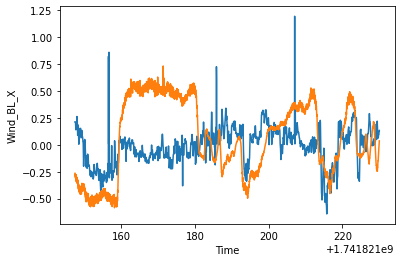

<function matplotlib.pyplot.show(*args, **kw)>

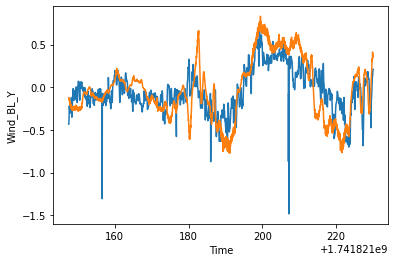

In [106]:
plt.plot(optic_flow_camera_x_time, Wind_BL_X_Scaled,label='Wind_X_f')
plt.plot(optic_flow_camera_x_time, X_DOT_BL_TRUE,label='X_DOT_BL_TRUE')
plt.xlabel('Time')
plt.ylabel('Wind_BL_X')
plt.show()

plt.plot(optic_flow_camera_x_time, Wind_BL_Y_Scaled,label='Wind_Y_f')
plt.plot(optic_flow_camera_x_time, Y_DOT_BL_TRUE,label='Y_DOT_BL_TRUE')
plt.xlabel('Time')
plt.ylabel('Wind_BL_Y')
plt.show

### Optic Flow Final

In [107]:
OF_BL_X, OF_BL_Y = rotate_optic_flow(optic_flow_camera_x, optic_flow_camera_y)
OF_BL_X_f = 1*optic_flow_scalar_X
OF_BL_Y_f = 1*optic_flow_scalar_Y
OF_BL_X_Scaled = np.multiply(OF_BL_X,OF_BL_X_f)
OF_BL_Y_Scaled = np.multiply(OF_BL_Y,OF_BL_Y_f)

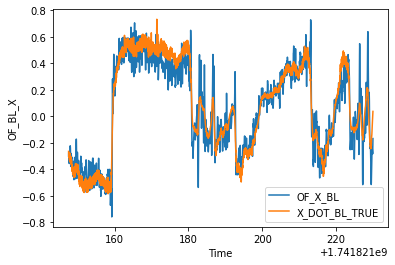

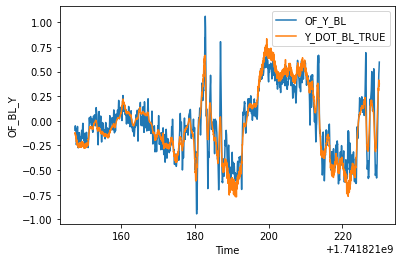

In [108]:
plt.plot(optic_flow_camera_x_time, np.multiply(OF_BL_X_Scaled,Z_TRUE),label='OF_X_BL')
plt.plot(optic_flow_camera_x_time, X_DOT_BL_TRUE,label='X_DOT_BL_TRUE')
plt.xlabel('Time')
plt.ylabel('OF_BL_X')
plt.legend()
plt.show()

plt.plot(optic_flow_camera_x_time, np.multiply(OF_BL_Y_Scaled,Z_TRUE),label='OF_Y_BL')
plt.plot(optic_flow_camera_x_time, Y_DOT_BL_TRUE,label='Y_DOT_BL_TRUE')
plt.xlabel('Time')
plt.ylabel('OF_BL_Y')
plt.legend()
plt.show()

### PWM Final

In [109]:
PWM_1 = (interpolate_data(rc_time, pwm_1, optic_flow_camera_x_time)-1150)/1000*9.81
PWM_2 = (interpolate_data(rc_time, pwm_2, optic_flow_camera_x_time)-1150)/1000*9.81
PWM_3 = (interpolate_data(rc_time, pwm_3, optic_flow_camera_x_time)-1150)/1000*9.81
PWM_4 = (interpolate_data(rc_time, pwm_4, optic_flow_camera_x_time)-1150)/1000*9.81

### Time

In [110]:
TIME_BL = optic_flow_camera_x_time-optic_flow_camera_x_time[0]
DT_BL=np.round(TIME_BL[1]-TIME_BL[0],2)
print(DT_BL)

0.03


# Real Drone Parameters

In [111]:
########################################################################################
#################### Real Drone Parameters #############################################
########################################################################################
Real_m   = 0.086  # [kg] mass
Real_M   = 2.529  # [kg] mass
Real_mM  = Real_M+4*Real_m  # [kg] mass (total=2.529+4*0.086=2.897)
Real_l   = 0.2032 # [m] length
Real_r   = 0.1778 # [m] average body radius
Real_Ix  = (2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2)*4 # [kg*m^2] moment of inertia
Real_Iy  = (2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2)*4 # [kg*m^2] moment of inertia
Real_Iz  = (2*(Real_M*Real_r**2)/5 + 4*Real_m*Real_l**2)*4 # [kg*m^2] moment of inertia
Real_Jr  = (2*(Real_M*Real_r**2)/5)*4 # [kg*m^2] polar moment of inertia ### FAKE VALUE
Real_b   = 1.8311 # thrust coefficient
Real_d   = 0.01 # drag coefficient
Real_Dl  = 0.01 # drag coefficient from ground speed plus air speed
Real_Dr  = 0.01 # drag coefficient from rotation speed
Real_C   = 0.1 # thrust coefficient

print('Real Drone Parameters:')
print('Real_m:       ', Real_m)
print('Real_M:       ', Real_M)
print('Real_M_total: ', Real_mM)
print('Real_l:       ', Real_l)
print('Real_r:       ', Real_r)
print('Real_Ix:      ', Real_Ix)
print('Real_Iy:      ', Real_Iy)
print('Real_Iz:      ', Real_Iz)
print('Real_Jr:      ', Real_Jr)
print('Real_b:       ', Real_b)
print('Real_d:       ', Real_d)
print('Real_Dl:      ', Real_Dl)
print('Real_Dr:      ', Real_Dr)


# params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
params = [Real_mM,Real_l,Real_Ix,Real_Iy,Real_Iz,Real_Jr,Real_b,Real_d,Real_Dl,Real_Dr]
g  = 9.81 # m/s^2

Real Drone Parameters:
Real_m:        0.086
Real_M:        2.529
Real_M_total:  2.8729999999999998
Real_l:        0.2032
Real_r:        0.1778
Real_Ix:       0.156325880896
Real_Iy:       0.156325880896
Real_Iz:       0.184733566016
Real_Jr:       0.127918195776
Real_b:        1.8311
Real_d:        0.01
Real_Dl:       0.01
Real_Dr:       0.01


# Cluster Measurments and Inputs

In [112]:
P_cluster = np.array(np.vstack([X_TRUE,Y_TRUE,Z_TRUE]))
V_BL_cluster = np.array(np.vstack([X_DOT_BL_TRUE,Y_DOT_BL_TRUE,Z_DOT_BL_TRUE]))
V_G_cluster = np.array(np.vstack([X_DOT_G_TRUE,Y_DOT_G_TRUE,Z_DOT_G_TRUE]))
Attitude_cluster = np.array(np.vstack([Roll_TRUE,Pitch_TRUE,Yaw_TRUE]))
Omega_cluster = np.array(np.vstack([IMU_OMEGA_X,IMU_OMEGA_Y,IMU_OMEGA_Z]))
Acc_BL_cluster = np.array(np.vstack([IMU_ACC_BL_X,IMU_ACC_BL_Y,IMU_ACC_BL_Z]))
IMU_cluster = np.array(np.vstack([IMU_ROLL, IMU_PITCH, IMU_YAW, IMU_OMEGA_X, IMU_OMEGA_Y,IMU_OMEGA_Z,IMU_ACC_BL_X,IMU_ACC_BL_Y,IMU_ACC_BL_Z]))
Wind_BL_XY_cluster = np.array(np.vstack([Wind_BL_X_Scaled,Wind_BL_Y_Scaled]))
Wind_BL_cluster = np.array(np.vstack([Wind_BL_X_Scaled,Wind_BL_Y_Scaled]))
OF_BL_cluster = np.array(np.vstack([OF_BL_X_Scaled,OF_BL_Y_Scaled]))

Y_BL = np.vstack((IMU_cluster,OF_BL_cluster,Wind_BL_cluster))

print(np.shape(Y_BL))

U_BL = np.array(np.vstack([PWM_1,PWM_2,PWM_3,PWM_4]))

print(np.shape(U_BL))


(13, 2475)
(4, 2475)


# Get the initial conditions

In [113]:
# X0_BL = np.atleast_2d(np.vstack((X_TRUE[0], # X
#                                  Y_TRUE[0], # Y
#                                  1/Z_TRUE[0], # 1/Z = mu
#                                  X_DOT_BL_TRUE[0], # X_DOT
#                                  Y_DOT_BL_TRUE[0], # Y_DOT
#                                  1/Z_DOT_BL_TRUE[0], # Z_DOT
#                                  IMU_ROLL[0], # ROLL
#                                  IMU_PITCH[0], # PITCH
#                                  IMU_YAW[0], # YAW
#                                  IMU_OMEGA_X[0], # OMEGA_X
#                                  IMU_OMEGA_Y[0], # OMEGA_Y
#                                  IMU_OMEGA_Z[0], # OMEGA_Z
#                                  0, # w_x
#                                  0, # w_y
#                                  Real_mM, # m
#                                  Real_Ix, # Ix
#                                  Real_Iy, # Iy
#                                  Real_Iz, # Iz
#                                  Real_C # C
#                                  )))

X0_BL = np.atleast_2d(np.vstack((X_TRUE[0], # X
                                 Y_TRUE[0], # Y
                                 1/Z_TRUE[0], # 1/Z = mu
                                 X_DOT_BL_TRUE[0], # X_DOT
                                 Y_DOT_BL_TRUE[0], # Y_DOT
                                 1/Z_DOT_BL_TRUE[0], # Z_DOT
                                 IMU_ROLL[0], # ROLL
                                 IMU_PITCH[0], # PITCH
                                 IMU_YAW[0], # YAW
                                 IMU_OMEGA_X[0], # OMEGA_X
                                 IMU_OMEGA_Y[0], # OMEGA_Y
                                 IMU_OMEGA_Z[0], # OMEGA_Z
                                 0, # w_x
                                 0 # w_y
                                 )))

print(np.shape(X0_BL))

(14, 1)


# System Covariance

In [114]:
Q_BL = np.diag(np.array([1.0e-2, # x
                         1.0e-2, # y
                         1.0e-20, # z
                         1.0e-2, # x_dot_body_level
                         1.0e-2, # y_dot_body_level
                         1.0e-20, # z_dot_body_level
                         1.0e-2, # roll (phi)
                         1.0e-2, # pitch (theta)
                         1.0e-2, # yaw (psi)
                         1.0e-1, # omega_x
                         1.0e-1, # omega_y
                         1.0e-1, # omega_z
                         1.0e-10, # wind_magnitude (w)
                         1.0e-10, # wind_direction (zeta)
                         1.0e-20, # m
                         1.0e-20, # Ix
                         1.0e-20, # Iy
                         1.0e-20, # Iz
                         1.0e-20])) # C

Q_BL = np.diag(np.array([1.0e-2, # x
                         1.0e-2, # y
                         1.0e-20, # z
                         1.0e-2, # x_dot_body_level
                         1.0e-2, # y_dot_body_level
                         1.0e-20, # z_dot_body_level
                         1.0e-2, # roll (phi)
                         1.0e-2, # pitch (theta)
                         1.0e-2, # yaw (psi)
                         1.0e-1, # omega_x
                         1.0e-1, # omega_y
                         1.0e-1, # omega_z
                         1.0e-10, # wind_magnitude (w)
                         1.0e-10 # wind_direction (zeta)
                         ])) # C

# Error covariance

X_TRUE_STD:  3.356782309854162
Y_TRUE_STD:  1.159590705274137
Z_TRUE_STD:  0.021524082273490494
X_DOT_BL_TRUE_STD:  0.35306313062268957
Y_DOT_BL_TRUE_STD:  0.34827779905695644
Z_DOT_BL_TRUE_STD:  0.06369788502536979
Roll_TRUE_STD:  1.884164779478971
Pitch_TRUE_STD:  1.3999228204718275
Yaw_TRUE_STD:  36.42362725069043
IMU_OMEGA_X_STD:  0.2591150792990619
IMU_OMEGA_Y_STD:  0.14023994918240326
IMU_OMEGA_Z_STD:  0.1788723838843423
IMU_ACC_BL_X_STD:  4.085487298284386
IMU_ACC_BL_Y_STD:  3.52630636254144
IMU_ACC_BL_Z_STD:  7.865557299071629
Wind_BL_X_Scaled_STD:  0.1686458662838651
Wind_BL_Y_Scaled_STD:  0.24832984063304744
Wind_BL_A_STD:  0.16239343676420706
Wind_BL_Gamma_STD:  1.736859901091523
OF_BL_X_Scaled_STD:  0.2803302482898873
OF_BL_Y_Scaled_STD:  0.2699982176805217
windX noise: 0.3574736922664042
windY noise: 0.23768322681853754
OFX noise: 0.1131144141674099
OFY noise: 0.13744515943179597


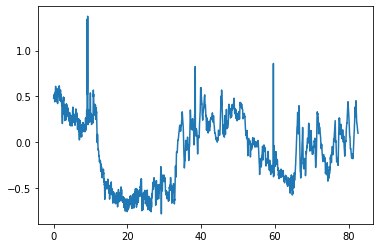

In [115]:
# get standard deviation of the data and make plus minus 3 sigma bounds
X_TRUE_STD = np.std(X_TRUE)
X_TRUE_PLUS = X_TRUE + 3*X_TRUE_STD
X_TRUE_MINUS = X_TRUE - 3*X_TRUE_STD
print("X_TRUE_STD: ", X_TRUE_STD)
Y_TRUE_STD = np.std(Y_TRUE)
Y_TRUE_PLUS = Y_TRUE + 3*Y_TRUE_STD
Y_TRUE_MINUS = Y_TRUE - 3*Y_TRUE_STD
print("Y_TRUE_STD: ", Y_TRUE_STD)
Z_TRUE_STD = np.std(Z_TRUE)
Z_TRUE_PLUS = Z_TRUE + 3*Z_TRUE_STD
Z_TRUE_MINUS = Z_TRUE - 3*Z_TRUE_STD
print("Z_TRUE_STD: ", Z_TRUE_STD)
X_DOT_BL_TRUE_STD = np.std(X_DOT_BL_TRUE)
X_DOT_BL_TRUE_PLUS = X_DOT_BL_TRUE + 3*X_DOT_BL_TRUE_STD
X_DOT_BL_TRUE_MINUS = X_DOT_BL_TRUE - 3*X_DOT_BL_TRUE_STD
print("X_DOT_BL_TRUE_STD: ", X_DOT_BL_TRUE_STD)
Y_DOT_BL_TRUE_STD = np.std(Y_DOT_BL_TRUE)
Y_DOT_BL_TRUE_PLUS = Y_DOT_BL_TRUE + 3*Y_DOT_BL_TRUE_STD
Y_DOT_BL_TRUE_MINUS = Y_DOT_BL_TRUE - 3*Y_DOT_BL_TRUE_STD
print("Y_DOT_BL_TRUE_STD: ", Y_DOT_BL_TRUE_STD)
Z_DOT_BL_TRUE_STD = np.std(Z_DOT_BL_TRUE)
Z_DOT_BL_TRUE_PLUS = Z_DOT_BL_TRUE + 3*Z_DOT_BL_TRUE_STD
Z_DOT_BL_TRUE_MINUS = Z_DOT_BL_TRUE - 3*Z_DOT_BL_TRUE_STD
print("Z_DOT_BL_TRUE_STD: ", Z_DOT_BL_TRUE_STD)
Roll_TRUE_STD = np.std(Roll_TRUE)
Roll_TRUE_PLUS = Roll_TRUE + 3*Roll_TRUE_STD
Roll_TRUE_MINUS = Roll_TRUE - 3*Roll_TRUE_STD
print("Roll_TRUE_STD: ", Roll_TRUE_STD)
Pitch_TRUE_STD = np.std(Pitch_TRUE)
Pitch_TRUE_PLUS = Pitch_TRUE + 3*Pitch_TRUE_STD
Pitch_TRUE_MINUS = Pitch_TRUE - 3*Pitch_TRUE_STD
print("Pitch_TRUE_STD: ", Pitch_TRUE_STD)
Yaw_TRUE_STD = np.std(Yaw_TRUE)
Yaw_TRUE_PLUS = Yaw_TRUE + 3*Yaw_TRUE_STD
Yaw_TRUE_MINUS = Yaw_TRUE - 3*Yaw_TRUE_STD
print("Yaw_TRUE_STD: ", Yaw_TRUE_STD)
IMU_OMEGA_X_STD = np.std(IMU_OMEGA_X)
IMU_OMEGA_X_PLUS = IMU_OMEGA_X + 3*IMU_OMEGA_X_STD
IMU_OMEGA_X_MINUS = IMU_OMEGA_X - 3*IMU_OMEGA_X_STD
print("IMU_OMEGA_X_STD: ", IMU_OMEGA_X_STD)
IMU_OMEGA_Y_STD = np.std(IMU_OMEGA_Y)
IMU_OMEGA_Y_PLUS = IMU_OMEGA_Y + 3*IMU_OMEGA_Y_STD
IMU_OMEGA_Y_MINUS = IMU_OMEGA_Y - 3*IMU_OMEGA_Y_STD
print("IMU_OMEGA_Y_STD: ", IMU_OMEGA_Y_STD)
IMU_OMEGA_Z_STD = np.std(IMU_OMEGA_Z)
IMU_OMEGA_Z_PLUS = IMU_OMEGA_Z + 3*IMU_OMEGA_Z_STD
IMU_OMEGA_Z_MINUS = IMU_OMEGA_Z - 3*IMU_OMEGA_Z_STD
print("IMU_OMEGA_Z_STD: ", IMU_OMEGA_Z_STD)
IMU_ACC_BL_X_STD = np.std(IMU_ACC_BL_X)
IMU_ACC_BL_X_PLUS = IMU_ACC_BL_X + 3*IMU_ACC_BL_X_STD
IMU_ACC_BL_X_MINUS = IMU_ACC_BL_X - 3*IMU_ACC_BL_X_STD
print("IMU_ACC_BL_X_STD: ", IMU_ACC_BL_X_STD)
IMU_ACC_BL_Y_STD = np.std(IMU_ACC_BL_Y)
IMU_ACC_BL_Y_PLUS = IMU_ACC_BL_Y + 3*IMU_ACC_BL_Y_STD
IMU_ACC_BL_Y_MINUS = IMU_ACC_BL_Y - 3*IMU_ACC_BL_Y_STD
print("IMU_ACC_BL_Y_STD: ", IMU_ACC_BL_Y_STD)
IMU_ACC_BL_Z_STD = np.std(IMU_ACC_BL_Z)
IMU_ACC_BL_Z_PLUS = IMU_ACC_BL_Z + 3*IMU_ACC_BL_Z_STD
IMU_ACC_BL_Z_MINUS = IMU_ACC_BL_Z - 3*IMU_ACC_BL_Z_STD
print("IMU_ACC_BL_Z_STD: ", IMU_ACC_BL_Z_STD)
Wind_BL_X_Scaled_STD = np.std(Wind_BL_X_Scaled)
Wind_BL_X_Scaled_PLUS = Wind_BL_X_Scaled + 3*Wind_BL_X_Scaled_STD
Wind_BL_X_Scaled_MINUS = Wind_BL_X_Scaled - 3*Wind_BL_X_Scaled_STD
print("Wind_BL_X_Scaled_STD: ", Wind_BL_X_Scaled_STD)
Wind_BL_Y_Scaled_STD = np.std(Wind_BL_Y_Scaled)
Wind_BL_Y_Scaled_PLUS = Wind_BL_Y_Scaled + 3*Wind_BL_Y_Scaled_STD
Wind_BL_Y_Scaled_MINUS = Wind_BL_Y_Scaled - 3*Wind_BL_Y_Scaled_STD
print("Wind_BL_Y_Scaled_STD: ", Wind_BL_Y_Scaled_STD)
Wind_BL_A_STD = np.std(Wind_BL_A)
Wind_BL_A_PLUS = Wind_BL_A + 3*Wind_BL_A_STD
Wind_BL_A_MINUS = Wind_BL_A - 3*Wind_BL_A_STD
print("Wind_BL_A_STD: ", Wind_BL_A_STD)
Wind_BL_Gamma_STD = np.std(Wind_BL_Gamma)
Wind_BL_Gamma_PLUS = Wind_BL_Gamma + 3*Wind_BL_Gamma_STD
Wind_BL_Gamma_MINUS = Wind_BL_Gamma - 3*Wind_BL_Gamma_STD
print("Wind_BL_Gamma_STD: ", Wind_BL_Gamma_STD)
OF_BL_X_Scaled_STD = np.std(OF_BL_X_Scaled)
OF_BL_X_Scaled_PLUS = OF_BL_X_Scaled + 3*OF_BL_X_Scaled_STD
OF_BL_X_Scaled_MINUS = OF_BL_X_Scaled - 3*OF_BL_X_Scaled_STD
print("OF_BL_X_Scaled_STD: ", OF_BL_X_Scaled_STD)
OF_BL_Y_Scaled_STD = np.std(OF_BL_Y_Scaled)
OF_BL_Y_Scaled_PLUS = OF_BL_Y_Scaled + 3*OF_BL_Y_Scaled_STD
OF_BL_Y_Scaled_MINUS = OF_BL_Y_Scaled - 3*OF_BL_Y_Scaled_STD
print("OF_BL_Y_Scaled_STD: ", OF_BL_Y_Scaled_STD)
# plt.plot(TIME_BL, IMU_OMEGA_X,label='IMU_OMEGA_X')
# plt.plot(TIME_BL, IMU_OMEGA_X_PLUS,label='IMU_OMEGA_X_PLUS')
# plt.plot(TIME_BL, IMU_OMEGA_X_MINUS,label='IMU_OMEGA_X_MINUS')

plt.plot(TIME_BL, Wind_BL_X_Scaled-X_DOT_BL_TRUE,label='Wind_noise')
print("windX noise:",np.std(Wind_BL_X_Scaled-X_DOT_BL_TRUE))
print("windY noise:",np.std(Wind_BL_Y_Scaled-Y_DOT_BL_TRUE))
print("OFX noise:",np.std(np.multiply(OF_BL_X_Scaled,Z_TRUE)-X_DOT_BL_TRUE))
print("OFY noise:",np.std(np.multiply(OF_BL_Y_Scaled,Z_TRUE)-Y_DOT_BL_TRUE))


In [116]:
P_V_cluster = np.vstack(np.array(([0.02,0.02,0.02])))
V_V_BL_cluster = np.vstack(np.array(([0.02,0.02,0.02])))
V_V_G_cluster = np.vstack(np.array(([0.02,0.02,0.02])))
Attitude_V_cluster = np.vstack(np.array(([0.02,0.02,0.02])))
Omega_V_cluster = np.vstack(np.array(([0.2,0.2,0.1])))
Acc_V_BL_cluster = np.vstack(np.array(([2,2,2])))
IMU_V_cluster = np.vstack(np.array(([0.0001, 0.0001, 0.0001, 0.2, 0.2, 0.2, 2, 2, 2])))
Wind_V_BL_XY_cluster = np.vstack(np.array(([0.2,0.4])))
Wind_V_BL_cluster = np.vstack(np.array(([0.2,0.2])))
OF_V_BL_cluster = np.vstack(np.array(([0.14,0.34])))

V_BL = np.vstack([IMU_V_cluster,OF_V_BL_cluster,Wind_V_BL_cluster])

R_BL = np.power(np.diag(V_BL.flatten()),2)

print(np.shape(R_BL))

(13, 13)


# Initial estimate covariance

In [117]:
# P0_BL = np.diag(np.array([1e-2, # x
#                        1e-2, # y
#                        1e-2, # z
#                        1e-2, # v_x
#                        1e-2, # v_y
#                        1e-2, # v_z
#                        1e-2, # phi
#                        1e-2, # theta
#                        1e-2, # psi
#                        1e-2, # omega_x
#                        1e-2, # omega_y
#                        1e-2, # omega_z
#                        1e-2, # w
#                        1e-2, # zeta
#                        1e-2, # m
#                        1e-2, # I_x
#                        1e-2, # I_y
#                        1e-2, # I_z
#                        1e-2])) # C

P0_BL = np.diag(np.array([1e-2, # x
                       1e-2, # y
                       1e-2, # z
                       1e-2, # v_x
                       1e-2, # v_y
                       1e-2, # v_z
                       1e-2, # phi
                       1e-2, # theta
                       1e-2, # psi
                       1e-2, # omega_x
                       1e-2, # omega_y
                       1e-2, # omega_z
                       1e-2, # w
                       1e-2 # zeta
                       ]))

# check sizes

In [118]:
# check that all inputs are a two-dimensional array
print('Ynoisy:',Y_BL.shape)
print('x0:',X0_BL.shape)
print('U:',U_BL.shape)
print('Q:',Q_BL.shape)
print('R:',R_BL.shape)
print('P0:',P0_BL.shape)

Ynoisy: (13, 2475)
x0: (14, 1)
U: (4, 2475)
Q: (14, 14)
R: (13, 13)
P0: (14, 14)


In [119]:
# drone_model = DroneModel()
# f_c=drone_model.f_c

# def outer(func):
#     def wrapper(*args, **kwargs):
#         global DT_BL
#         args = list(args) + [DT_BL]
#         value = func(*args)
#         return value
#     return wrapper

# f_c = outer(drone_model.f_c)

drone_model = DroneModel()
f_c=drone_model.f_c_mu

def outer(func):
    def wrapper(*args, **kwargs):
        global DT_BL
        args = list(args) + [DT_BL]
        value = func(*args)
        return value
    return wrapper

f_c = outer(drone_model.f_c_mu)

In [120]:
# h_c=drone_model.h_c
h_c=drone_model.h_c_mu

In [121]:
xhat_BL, P_BL, s_BL = EKF(Y_BL, X0_BL, f_c, h_c, Q_BL, R_BL, U_BL, P0_BL)

In [123]:
x_hat_BL = xhat_BL[0,:]  # x estimate
y_hat_BL = xhat_BL[1,:]  # y estimate
z_hat_BL = xhat_BL[2,:]  # z estimate
v_x_hat_BL = xhat_BL[3,:]  # v_x estimate
v_y_hat_BL = xhat_BL[4,:]  # v_y estimate
v_z_hat_BL = xhat_BL[5,:]  # v_z estimate
phi_hat_BL = xhat_BL[6,:]  # phi estimate
theta_hat_BL = xhat_BL[7,:]  # theta estimate
psi_hat_BL = xhat_BL[8,:]  # psi estimate
omega_x_hat_BL = xhat_BL[9,:]  # omega_x estimate
omega_y_hat_BL = xhat_BL[10,:]  # omega_y estimate
omega_z_hat_BL = xhat_BL[11,:]  # omega_z estimate
w_hat_BL = xhat_BL[12,:]  # w estimate
zeta_hat_BL = xhat_BL[13,:]  # zeta estimate
# m_hat_BL = xhat_BL[14,:]  # m estimate
# I_x_hat_BL = xhat_BL[15,:]  # I_x estimate
# I_y_hat_BL = xhat_BL[16,:]  # I_y estimate
# I_z_hat_BL = xhat_BL[17,:]  # I_z estimate
# C_hat_BL = xhat_BL[18,:]  # C estimate

ValueError: shape mismatch: objects cannot be broadcast to a single shape

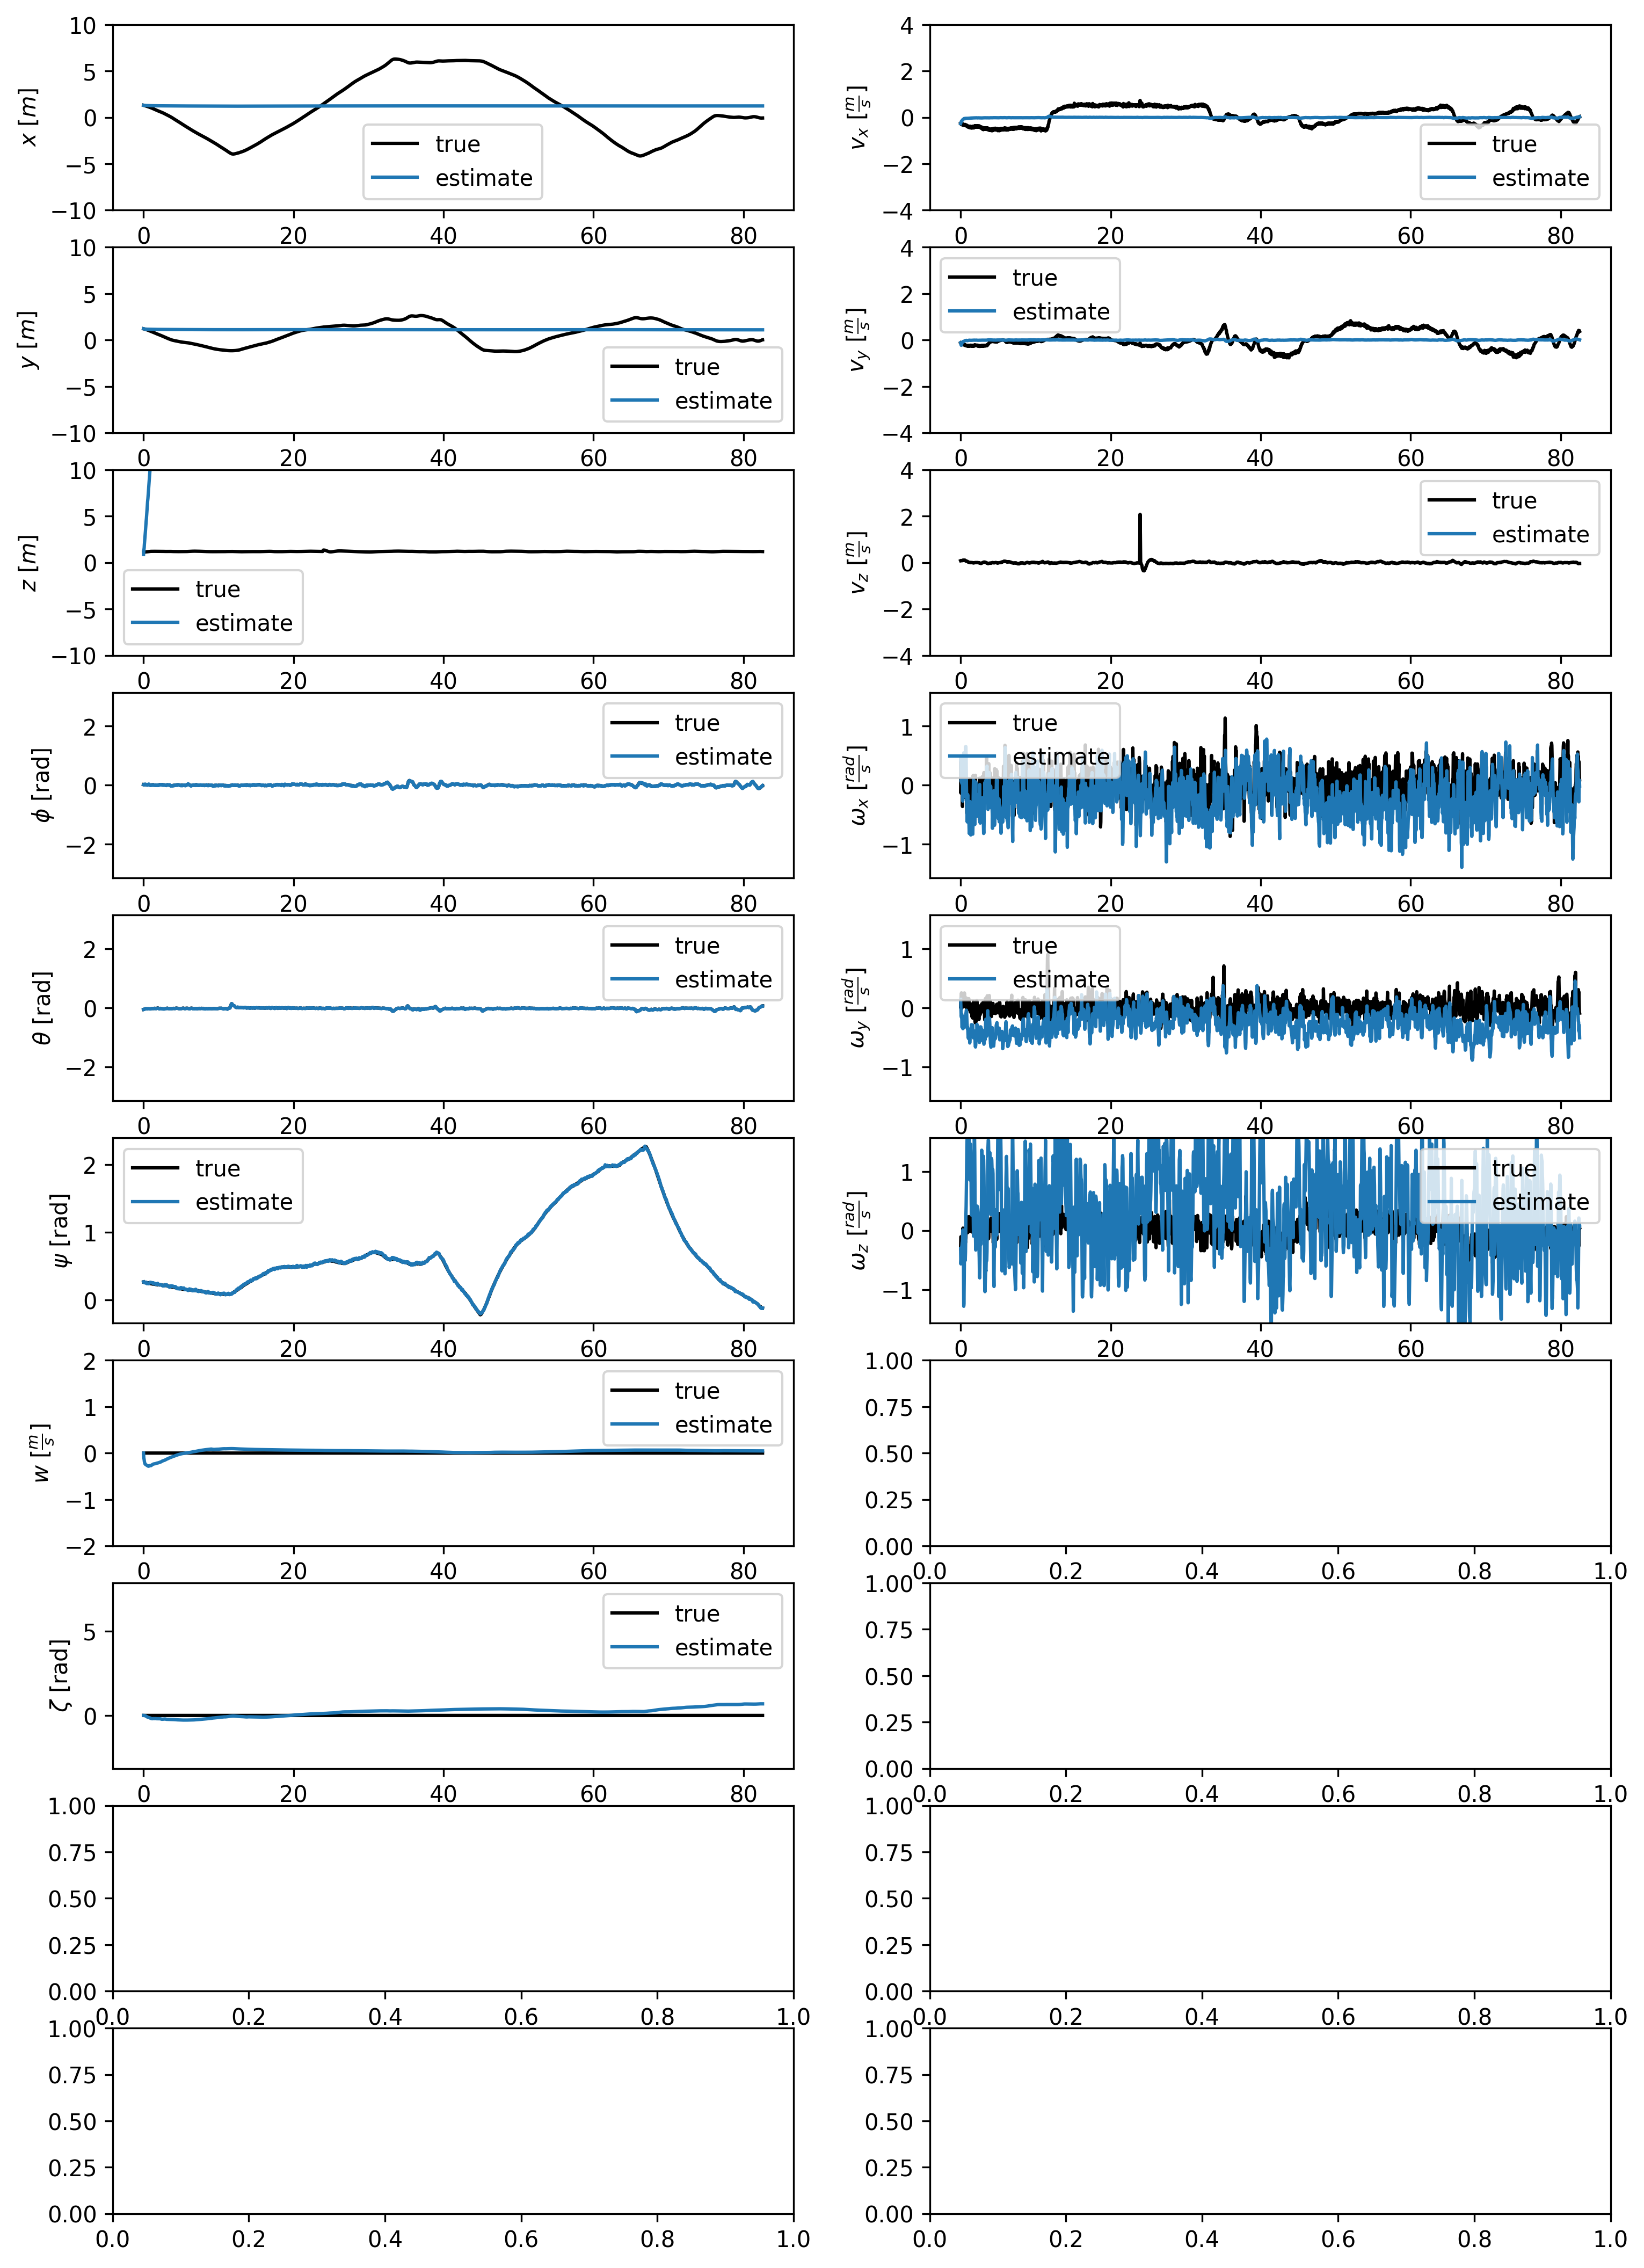

In [124]:
# plot the estimated states and the true states all on the same figure
# 19 states make the plots 10 by 2
fig, ax = plt.subplots(10, 2, figsize=(3 * 4, 3 * 6), dpi=300)

# plot x
ax[0, 0].plot(TIME_BL, X_TRUE, label='true', color='black')
ax[0, 0].plot(TIME_BL, x_hat_BL, label='estimate')
ax[0, 0].set_ylabel('$x$ [$m$]')
ax[0, 0].set_ylim(-10, 10)
ax[0, 0].legend()

# plot y
ax[1, 0].plot(TIME_BL, Y_TRUE, label='true', color='black')
ax[1, 0].plot(TIME_BL, y_hat_BL, label='estimate')
ax[1, 0].set_ylabel('$y$ [$m$]')
ax[1, 0].set_ylim(-10, 10)
ax[1, 0].legend()

# plot z
ax[2, 0].plot(TIME_BL, Z_TRUE, label='true', color='black')
ax[2, 0].plot(TIME_BL, z_hat_BL, label='estimate')
ax[2, 0].set_ylabel('$z$ [$m$]')
ax[2, 0].set_ylim(-10, 10)
ax[2, 0].legend()

# plot v_x
ax[0, 1].plot(TIME_BL, X_DOT_BL_TRUE, label='true', color='black')
ax[0, 1].plot(TIME_BL, v_x_hat_BL, label='estimate')
ax[0, 1].set_ylabel(r'$v_x$ [$\frac{m}{s}$]')
ax[0, 1].set_ylim(-4, 4)
ax[0, 1].legend()

# plot v_y
ax[1, 1].plot(TIME_BL, Y_DOT_BL_TRUE, label='true', color='black')
ax[1, 1].plot(TIME_BL, v_y_hat_BL, label='estimate')
ax[1, 1].set_ylabel(r'$v_y$ [$\frac{m}{s}$]')
ax[1, 1].set_ylim(-4, 4)
ax[1, 1].legend()

# plot v_z
ax[2, 1].plot(TIME_BL, Z_DOT_BL_TRUE, label='true', color='black')
ax[2, 1].plot(TIME_BL, v_z_hat_BL, label='estimate')
ax[2, 1].set_ylabel(r'$v_z$ [$\frac{m}{s}$]')
ax[2, 1].set_ylim(-4, 4)
ax[2, 1].legend()

# plot phi
ax[3, 0].plot(TIME_BL, IMU_ROLL, label='true', color='black')
ax[3, 0].plot(TIME_BL, phi_hat_BL, label='estimate')
ax[3, 0].set_ylabel('$\phi$ [rad]')
ax[3, 0].set_ylim(-1*np.pi, 1*np.pi)
ax[3, 0].legend()

# plot theta
ax[4, 0].plot(TIME_BL, IMU_PITCH, label='true', color='black')
ax[4, 0].plot(TIME_BL, theta_hat_BL, label='estimate')
ax[4, 0].set_ylabel(r'$\theta$ [rad]')
ax[4, 0].set_ylim(-1*np.pi, 1*np.pi)
ax[4, 0].legend()

# plot psi
ax[5, 0].plot(TIME_BL, IMU_YAW, label='true', color='black')
ax[5, 0].plot(TIME_BL, psi_hat_BL, label='estimate')
ax[5, 0].set_ylabel('$\psi$ [rad]')
# ax[5, 0].set_ylim(-2*np.pi, 5*np.pi)
ax[5, 0].legend()

# plot omega_x
ax[3, 1].plot(TIME_BL, IMU_OMEGA_X, label='true', color='black')
ax[3, 1].plot(TIME_BL, omega_x_hat_BL, label='estimate')
ax[3, 1].set_ylabel(r'$\omega_x$ [$\frac{rad}{s}$]')
ax[3, 1].set_ylim(-0.5*np.pi, 0.5*np.pi)
ax[3, 1].legend()

# plot omega_y
ax[4, 1].plot(TIME_BL, IMU_OMEGA_Y, label='true', color='black')
ax[4, 1].plot(TIME_BL, omega_y_hat_BL, label='estimate')
ax[4, 1].set_ylabel(r'$\omega_y$ [$\frac{rad}{s}$]')
ax[4, 1].set_ylim(-0.5*np.pi, 0.5*np.pi)
ax[4, 1].legend()

# plot omega_z
ax[5, 1].plot(TIME_BL, IMU_OMEGA_Z, label='true', color='black')
ax[5, 1].plot(TIME_BL, omega_z_hat_BL, label='estimate')
ax[5, 1].set_ylabel(r'$\omega_z$ [$\frac{rad}{s}$]')
ax[5, 1].set_ylim(-0.5*np.pi, 0.5*np.pi)
ax[5, 1].legend()

# plot w
ax[6, 0].plot(TIME_BL, np.zeros_like(TIME_BL), label='true', color='black')
ax[6, 0].plot(TIME_BL, w_hat_BL, label='estimate')
ax[6, 0].set_ylabel(r'$w$ [$\frac{m}{s}$]')
ax[6, 0].set_ylim(-2, 2)
ax[6, 0].legend()

# plot zeta
ax[7, 0].plot(TIME_BL, np.zeros_like(TIME_BL), label='true', color='black')
ax[7, 0].plot(TIME_BL, zeta_hat_BL, label='estimate')
ax[7, 0].set_ylabel('$\zeta$ [rad]')
ax[7, 0].set_ylim(-np.pi, 2.5*np.pi)
ax[7, 0].legend()

# # plot m
# ax[8, 0].plot(TIME_BL, np.ones_like(TIME_BL)*Real_mM, label='true', color='black')
# ax[8, 0].plot(TIME_BL, m_hat_BL, label='estimate')
# ax[8, 0].set_ylabel('$m$ [kg]')
# # ax[8, 0].set_ylim(0, .2)
# ax[8, 0].legend()

# # plot C
# ax[9, 0].plot(TIME_BL, np.ones_like(TIME_BL)*Real_C, label='true', color='black')
# ax[9, 0].plot(TIME_BL, C_hat_BL, label='estimate')
# ax[9, 0].set_ylabel('$C$')
# # ax[9, 0].set_ylim(0, .15)
# ax[9, 0].legend()

# # plot I_x
# ax[6, 1].plot(TIME_BL, np.ones_like(TIME_BL)*Real_Ix, label='true', color='black')
# ax[6, 1].plot(TIME_BL, I_x_hat_BL, label='estimate')
# ax[6, 1].set_ylabel('$I_x$ [$kg*m^2$]')
# # ax[6, 1].set_ylim(0, .09)
# ax[6, 1].legend()

# # plot I_y
# ax[7, 1].plot(TIME_BL, np.ones_like(TIME_BL)*Real_Iy, label='true', color='black')
# ax[7, 1].plot(TIME_BL, I_y_hat_BL, label='estimate')
# ax[7, 1].set_ylabel('$I_y$ [$kg*m^2$]')
# # ax[7, 1].set_ylim(0, .09)
# ax[7, 1].legend()

# # plot I_z
# ax[8, 1].plot(TIME_BL, np.ones_like(TIME_BL)*Real_Iz, label='true', color='black')
# ax[8, 1].plot(TIME_BL, I_z_hat_BL, label='estimate')
# ax[8, 1].set_ylabel('$I_z$ [$kg*m^2$]')
# # ax[8, 1].set_ylim(0, .09)
# ax[8, 1].legend()

# Calculate RMSE between true and estimated states
RMSE_x = np.sqrt(np.mean((X_TRUE - x_hat_BL) ** 2))
RMSE_y = np.sqrt(np.mean((Y_TRUE - y_hat_BL) ** 2))
RMSE_z = np.sqrt(np.mean((Z_TRUE - z_hat_BL) ** 2))
RMSE_v_x = np.sqrt(np.mean((X_DOT_BL_TRUE - v_x_hat_BL) ** 2))
RMSE_v_y = np.sqrt(np.mean((Y_DOT_BL_TRUE - v_y_hat_BL) ** 2))
RMSE_v_z = np.sqrt(np.mean((Z_DOT_BL_TRUE - v_z_hat_BL) ** 2))
RMSE_phi = np.sqrt(np.mean((IMU_ROLL - phi_hat_BL) ** 2))
RMSE_theta = np.sqrt(np.mean((IMU_PITCH - theta_hat_BL) ** 2))
RMSE_psi = np.sqrt(np.mean((IMU_YAW - psi_hat_BL) ** 2))
RMSE_omega_x = np.sqrt(np.mean((IMU_OMEGA_X - omega_x_hat_BL) ** 2))
RMSE_omega_y = np.sqrt(np.mean((IMU_OMEGA_Y - omega_y_hat_BL) ** 2))
RMSE_omega_z = np.sqrt(np.mean((IMU_OMEGA_Z - omega_z_hat_BL) ** 2))
RMSE_w = np.sqrt(np.mean((np.zeros_like(TIME_BL) - w_hat_BL) ** 2))
RMSE_zeta = np.sqrt(np.mean((np.zeros_like(TIME_BL) - zeta_hat_BL) ** 2))
# RMSE_m = np.sqrt(np.mean((np.ones_like(TIME_BL) * Real_mM - m_hat_BL) ** 2))
# RMSE_I_x = np.sqrt(np.mean((np.ones_like(TIME_BL) * Real_Ix - I_x_hat_BL) ** 2))
# RMSE_I_y = np.sqrt(np.mean((np.ones_like(TIME_BL) * Real_Iy - I_y_hat_BL) ** 2))
# RMSE_I_z = np.sqrt(np.mean((np.ones_like(TIME_BL) * Real_Iz - I_z_hat_BL) ** 2))
# RMSE_C = np.sqrt(np.mean((np.ones_like(TIME_BL) * Real_C - C_hat_BL) ** 2))

# Combine RMSE values into an array
# RMSE = np.array([RMSE_x, RMSE_y, RMSE_z, RMSE_v_x, RMSE_v_y, RMSE_v_z, RMSE_phi, RMSE_theta, RMSE_psi, RMSE_omega_x, RMSE_omega_y, RMSE_omega_z, RMSE_w, RMSE_zeta, RMSE_m, RMSE_I_x, RMSE_I_y, RMSE_I_z, RMSE_C])
RMSE = np.array([RMSE_x, RMSE_y, RMSE_z, RMSE_v_x, RMSE_v_y, RMSE_v_z, RMSE_phi, RMSE_theta, RMSE_psi, RMSE_omega_x, RMSE_omega_y, RMSE_omega_z, RMSE_w, RMSE_zeta])
# Plot RMSE as a bar graph
ax[9, 1].bar(np.arange(19), RMSE)
ax[9, 1].set_ylabel('RMSE')
ax[9, 1].set_xticks(np.arange(19))
# Write x tick labels in LaTeX format
ax[9, 1].set_xticklabels(['$x$', '$y$', '$z$', '$v_x$', '$v_y$', '$v_z$', '$\phi$', r'$\theta$', '$\psi$', '$\omega_x$', '$\omega_y$', '$\omega_z$', '$w$', '$\zeta$', '$m$', '$I_x$', '$I_y$', '$I_z$', '$C$'])
ax[9, 1].set_xticklabels(['$x$', '$y$', '$z$', '$v_x$', '$v_y$', '$v_z$', '$\phi$', r'$\theta$', '$\psi$', '$\omega_x$', '$\omega_y$', '$\omega_z$', '$w$', '$\zeta$'])
plt.show()